# Topic Modeling on Twitter Data with LDA using PySparkML

In [1]:
# !pip3 install nb_black==1.0.7 nltk==3.6.6 altair==4.1.0

In [2]:
%load_ext lab_black
%load_ext autoreload
%autoreload 2

In [3]:
import os
import time
from datetime import datetime
from functools import reduce
from typing import List

import boto3
import nltk
import sagemaker_pyspark
from pandas import Series as pd_Series
from pyspark import SparkConf, keyword_only
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.clustering import LDA
from pyspark.ml.feature import (
    CountVectorizer,
    CountVectorizerModel,
    IDF,
    RegexTokenizer,
    StopWordsRemover,
    Tokenizer,
    VectorAssembler,
)
from pyspark.sql import Column, SparkSession, functions as F, types as T
from pyspark.sql.dataframe import DataFrame as pdf
from pyspark.sql.window import Window

In [4]:
# used for display purposes only
from pandas import DataFrame as pd_DataFrame, option_context as pd_option_context

# only used to verify that data containing ML model predictions, which was exported to S3, can
# be re-loaded (into a Dask or Pandas DataFrame)
import dask.dataframe as dd
from pandas import read_parquet as pd_read_parquet

In [5]:
%aimport src.model_interpretation
from src.model_interpretation import interpret_model as mih, import_export_models as iem

%aimport src.nlp
from src.nlp import clean_text as ch

%aimport src.s3
from src.s3 import bucket_contents as s3h

%aimport src.visualization
from src.visualization import visualize as vh

## About

In this notebook, PySpark ML will be used to perform topic modeling on the streamed tweets data stored in the CSV files (prepared using `3_combine_raw_data.ipynb`) in an S3 bucket.

**Notes**
1. This is an initial attempt at unsupervised learning with this data. The objective is to build up a minimum reliable end-to-end workflow here consisting of **both**
   - complete data processing
     - with an emphasis on processing text data
   - unsupervised ML
     - with manual hyper-parameter adjustments

   each of which can be iteratively improved in the future.
2. As the requirement for this project is to use big-data tools only, we will restrict ourselves to using
   - PySpark for manipulating the data in a PySpark `DataFrame`
     - even though the dataset used here does fit in memory and could be analysed using in-memory tools
   - PySpark ML for implementing topic modeling (unsupervised machine learning)
3. An AWS SageMaker notebook hosted on a T3 XLarge instance ([specifications](https://aws.amazon.com/ec2/instance-types/)) was used for running this notebook.
4. To ensure repeatability in
   - applying NLP on the tweet text
     - the previous (most recently) trained vectorizer model will be loaded from a sub-folder in the same S3 bucket containing the CSV files
       - here, this was done after reasonable choices for the `minDF` and `maxDF` hyper-parameters of the vectorizer model were found (from tuning these two hyper-parameters manually) and only the topic modeling algorithm (LDA) was left to be optimized
     - a newly defined vectorizer model will be trained and saved (with a timestamp in the suffix of its filename) to a sub-folder in the same S3 bucket
   - applying LDA [randomness in LDA is due to the probabilistic aspect of this algorithm ([1](https://stackoverflow.com/a/60661226/4057186))]
     - the `seed` hyper-parameter in the PySparkML `LDA` object will be set to a fixed value
       - this is used to save the state of a random function, so it yields the same random numbers on multiple calls
     - the LDA hyper-parameter for the maximum number of iterations (`maxIter`, [link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.LDA.html#pyspark.ml.clustering.LDA.maxIter)) will need to be increased sufficiently (from its default value of 20) such that the learned topics do converge
       - a best effort was made to optimize this choice manually

**Requirements**
1. This notebook must be run on an AWS SageMaker instance.
2. Required Python libraries can be installed by un-commenting the first cell of this notebook.
3. Two environment variables
   - `AWS_S3_BUCKET_NAME`
      - the name of the S3 bucket containing the hourly CSVs of streamed Twitter data
   - `AWS_REGION`

   must be accessible to this SageMaker instance.

The Python package requirements to run this notebook are different to those listed in the `requirements.txt` file (used by notebook `3_combine_raw_data.ipynb`) for this project

In [6]:
%%time
!pip3 freeze | grep -E 'boto3|s3fs|black==|jupyter-server|sagemaker|sagemaker_pyspark|pandas|pyspark|dask|nltk|altair|plotly'

altair==4.1.0
boto3==1.20.25
dask==2021.3.0
jupyter-server==1.13.0
nb-black==1.0.7
nltk==3.6.6
pandas==1.1.5
plotly==5.4.0
pyspark==2.4.0
s3fs==2021.4.0
sagemaker==2.72.1
sagemaker-pyspark==1.4.2
CPU times: user 17.9 ms, sys: 8.3 ms, total: 26.2 ms
Wall time: 974 ms


## User Inputs

In [7]:
# S3
path_to_folder = "/datasets/twitter/kinesis-demo/"

# Data Loading (from hourly CSV files)
num_files_to_use = 25
# number of rows (streamed tweets) to load into PySpark DataFrame
nrows = 800_000

# Data processing
all_cols_to_process = [
    "document",  # 'document' is optional
    "created_at",
    "user_joined",
    "in_reply_to_screen_name",
    "source_text",
    "place_country",
    "user_followers",
    "user_friends",
    "user_listed",
    "user_favourites",
    "user_statuses",
    "user_protected",
    "user_verified",
    "user_location",
    "reviewText",
]

# Vectorizer
count_vectorizer_filename = "count_vec_model"
save_count_vectorizer = False
s3_models_subfolder = "models"  # note: change this from 'predictions' to 'models'

# LDA
# # this should be tuned iteratively (discussed later)
num_topics = 4

# Model Evaluation (for reading tweets predicted to belong to the same topic)
num_top_terms_per_topic = 15
num_top_docs_to_read = 8

# Output file (containing data with predicted topic)
output_file_name = "processed_with_predictions"

In [8]:
s3_bucket_name = os.getenv("AWS_S3_BUCKET_NAME")
aws_region = os.getenv("AWS_REGION")

In [9]:
topic_cols = [f"topic_{i}" for i in range(num_topics)]
cols_to_show_when_reading = (
    ["document", "reviewText"] + topic_cols + ["dominant_prob", "dominant_topic"]
)

In [10]:
def show_pyspark_df(df: pdf, nrows: int = 5) -> pd_DataFrame:
    """Display the first n rows of a PySpark DataFrame as a Pandas DataFrame."""
    return df.limit(nrows).toPandas()

Download NLTK stopwords, if not previously done

In [11]:
%%time
if not os.path.isdir(
    os.path.join(os.path.expanduser("~"), "nltk_data", "corpora", "stopwords")
):
    nltk.download("stopwords")

from nltk.corpus import stopwords

all_stopwords = set(stopwords.words("english"))

CPU times: user 1.75 ms, sys: 0 ns, total: 1.75 ms
Wall time: 1.49 ms


Append custom stopwords to the list of stopwords provied by the NLTK library

In [12]:
manual_stop_words = [
    # specific to crypto mining
    "crypto",
    "token",
    "koistarter",
    "daostarter",
    "decentralized",
    "services",
    "pancakeswap",
    "eraxnft",
    "browsing",
    "kommunitas",
    "hosting",
    "internet",
    "exipofficial",
    "servers",
    "wallet",
    "liquidity",
    "rewards",
    "floki",
    "10000000000000linkstelegram",
    "dogecoin",
    "czbinance",
    "watch",
    "binance",
    "dogelonmars",
    "cryptocurrency",
    "hbomax",
    "money",
    "danheld",
    "dogelon",
    "bitcoin",
    "nftart",
    "bvbtc",
    # inappropriate
    "fuckkk",
    "fucking",
    # general words that won't be useful to analysis here (subjective choices)
    "provides",
    "crazy",
    "marketing",
    "locked",
    "happy",
    "first",
    "would",
    "always",
    "still",
    "could",
    "right",
    "thank",
    "project",
    "great",
    "really",
    "think",
    "check",
    "supply",
    "going",
    "completed",
    "still",
    "people",
    "years",
    "matter",
    "never",
    "always",
    "things",
    "amazing",
    "around",
    "better",
    "another",
    "please",
    "looking",
    "today",
    "since",
    "thing",
    "every",
    "something",
    "future",
    "thanks",
    "youre",
    "don't",
    "don't",
    "someone",
    "ready",
    "taken",
    "using",
    "enough",
    "maybe",
    "believe",
    "making",
    "stuff",
    "might",
    "point",
    "makes",
    "family",
    "everyone",
    "thats",
    "actually",
    "everything",
    "little",
    "change",
    "without",
    "gonna",
    "already",
    "getting",
    "theres",
    "looks",
    "can't",
    "didn't",
    "called",
    "found",
    "nothing",
    "though",
    "literally",
    "bring",
    # not words
    "aaaaaaaaaa",
    "aaaaaand",
    "aaaaand",
    "aaaahhhh",
    "aaaand",
    "aaaaaa",
    "aaahh",
    "aaare",
]
# Manually add to stop words
for manual_stop_word in manual_stop_words:
    all_stopwords.add(manual_stop_word)
all_stopwords = list(all_stopwords)

**Notes**
1. This custom list was iteratively built up by training the topic model algorithm, inspecting the top words in each learned topic and removing any occurrences of commonly occurring words that were (subjectively) determined to not add value to the topic. Such words should not contribute the highest weight to a topic and so should be removed from the text vocabulary that is used here.
2. Sine we're trying to learn topics related to tweets about *space* news, tweets about crypto currency (which are likely being picked up due to their connection to the company SpaceX) are not useful and should be removed from the vocabulary. An alternative approach would be to keep those words in and choose a number of topics that (if possible) confines tweets about crypto-current to a single topic. This alternate approach was not used here.

## PySpark Setup (on AWS SageMaker)

In [13]:
%%time
conf = (SparkConf()
        .set("spark.driver.extraClassPath", ":".join(sagemaker_pyspark.classpath_jars())))

CPU times: user 886 µs, sys: 148 µs, total: 1.03 ms
Wall time: 837 µs


Start a Spark session

In [14]:
%%time
spark = (
    SparkSession
    .builder
    .config(conf=conf)
    .appName("schema_test")
    .getOrCreate()
)

CPU times: user 28.4 ms, sys: 4.75 ms, total: 33.2 ms
Wall time: 3.41 s


## Load Data

### Get List of S3 CSV Data Files

Get a list of all the CSV files containing the tweets data (files with a prefix `tweets_*.csv`), and not the metadata (prefix `tweets_metadata_*.csv`), from `csvs/` folder in the S3 bucket path at `<bucket-name>/datasets/twitter/kinesis-demo/`

In [15]:
%%time
existing_csv_files_list = s3h.get_existing_csv_files_list(
    s3_bucket_name, path_to_folder[1:] + "csvs/tweets_"
)
files_csvs_list = [f for f in existing_csv_files_list if "metadata" not in f]
files_csvs_list

CPU times: user 112 ms, sys: 32.5 ms, total: 144 ms
Wall time: 217 ms


['datasets/twitter/kinesis-demo/csvs/tweets_15_hc2021123017_s20220106193315.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_40_hc2021123118_s20220106193321.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_57_hc2022010416_s20220106195607.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2021123119_s20220106193331.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2021123122_s20220106193423.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010100_s20220106193454.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010104_s20220106193556.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010107_s20220106193641.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010109_s20220106193710.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010112_s20220106193752.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010116_s20220106193852.csv',
 'datasets/twitter/kinesis-demo/csvs/tweets_58_hc2022010120_s20220106193954.csv',
 'datasets/twitt

### Load all CSV Files into Single PySpark `DataFrame`

Read all CSV files from the `csvs/` in the S3 bucket path at `<bucket-name>/datasets/twitter/kinesis-demo/` into a PySpark `DataFrame`

In [16]:
schema = T.StructType(
    [
        T.StructField("id", T.StringType()),
        T.StructField("contributors", T.StringType()),
        T.StructField("created_at", T.StringType()),
        T.StructField("source", T.StringType()),
        T.StructField("in_reply_to_screen_name", T.StringType()),
        T.StructField("source_text", T.StringType()),
        T.StructField("place_id", T.StringType()),
        T.StructField("place_url", T.StringType()),
        T.StructField("place_place_type", T.StringType()),
        T.StructField("place_country_code", T.StringType()),
        T.StructField("place_country", T.StringType()),
        T.StructField("user_name", T.StringType()),
        T.StructField("user_screen_name", T.StringType()),
        T.StructField("user_followers", T.IntegerType()),
        T.StructField("user_friends", T.IntegerType()),
        T.StructField("user_listed", T.IntegerType()),
        T.StructField("user_favourites", T.IntegerType()),
        T.StructField("user_statuses", T.IntegerType()),
        T.StructField("user_protected", T.BooleanType()),
        T.StructField("user_verified", T.BooleanType()),
        T.StructField("user_joined", T.StringType()),
        T.StructField("user_location", T.StringType()),
        T.StructField("retweeted_tweet", T.StringType()),
        T.StructField("text", T.StringType()),
        T.StructField("file_name", T.StringType()),
    ]
)

In [17]:
%%time
df = spark.read.csv(
    [f's3a://{s3_bucket_name}' + f"/{f}" for f in files_csvs_list],
    header=True,
    schema=schema,
    # inferSchema=True
).withColumnRenamed("text", "reviewText")
df = df.limit(nrows)

CPU times: user 16.8 ms, sys: 2.09 ms, total: 18.9 ms
Wall time: 6.63 s


(Optional) Add a row number (row counter) column to the data

In [18]:
%%time
w = Window().orderBy(F.lit('A'))
df = df.withColumn("document", F.row_number().over(w))
with pd_option_context("display.max_columns", 50):
    display(show_pyspark_df(df))

,id,contributors,created_at,source,in_reply_to_screen_name,source_text,place_id,place_url,place_place_type,place_country_code,place_country,user_name,user_screen_name,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_joined,user_location,retweeted_tweet,reviewText,file_name,document
0,1478758349764059139,None,2022-01-05 16:00:39+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",cheemsisjesus,Twitter Web App,None,None,None,None,None,Robert Evans,LordJesusMinion,108,775,0,536,700,False,False,2021-12-22 13:26:45+00:00,None,no,"Yes, indeed there is: aka aka aka ...",twitter_delivery_stream-1-2022-01-05-16-00-44-...,1
1,1477802540272021505,None,2022-01-03 00:42:36+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",SnakeFragile,Twitter Web App,None,None,None,None,None,James Hawke,James_Hawke1,296,593,2,2476,5923,False,False,2021-10-27 22:00:18+00:00,Ausganistan,no,""" Prove how """"Gravity!"""" makes spheres ...",twitter_delivery_stream-1-2022-01-03-00-42-19-...,2
2,1478758350229848065,None,2022-01-05 16:00:39+00:00,"""<a href=""""http://twitter.com/download/iphone""...",SpaceX,Twitter for iPhone,None,None,None,None,None,NFT_d4ni3L,nft_d4ni3l,158,230,1,4092,2271,False,False,2018-01-21 00:36:55+00:00,Deutschland,no,"Mr. , can you resuscitate the project. ...",twitter_delivery_stream-1-2022-01-05-16-00-44-...,3
3,1477802565198880772,None,2022-01-03 00:42:42+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",None,Twitter Web App,None,None,None,None,None,Marine Technology,MarineTechnolo1,864,3829,32,5939,11315,False,False,2012-09-04 19:51:58+00:00,Florida,no,Russia’s space agency has sent an actor and a ...,twitter_delivery_stream-1-2022-01-03-00-42-19-...,4
4,1478758353262235651,None,2022-01-05 16:00:40+00:00,"""<a href=""""https://ifttt.com"""" rel=""""nofollow""...",None,IFTTT,None,None,None,None,None,John Burke,ImRetiredAtLast,1207,1733,177,566,85772,False,False,2011-07-17 21:24:14+00:00,Great White North,no,NASA’s X-59 Kicks Off 2022 in Texas for Ground...,twitter_delivery_stream-1-2022-01-05-16-00-44-...,5


CPU times: user 36.7 ms, sys: 6.91 ms, total: 43.6 ms
Wall time: 13.9 s


Get the number of rows (retrieved tweets) in the data, number of pyspark `DataFrame` partitions and the number of workers on the host (single-node) cluster

In [19]:
%%time
print(
    f"Raw data contains {df.count():,} rows and {len(df.columns):,} columns "
    f"in {df.rdd.getNumPartitions()} partitions, on a host with "
    f"{len(os.sched_getaffinity(0))} CPUs"
)

Raw data contains 623,089 rows and 26 columns in 1 partitions, on a host with 4 CPUs
CPU times: user 1.32 ms, sys: 1.67 ms, total: 2.99 ms
Wall time: 4.14 s


Show the first 4 rows from the PySpark `DataFrame`

In [20]:
%%time
with pd_option_context("display.max_columns", 100):
    display(show_pyspark_df(df, 4))

,id,contributors,created_at,source,in_reply_to_screen_name,source_text,place_id,place_url,place_place_type,place_country_code,place_country,user_name,user_screen_name,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_joined,user_location,retweeted_tweet,reviewText,file_name,document
0,1478758349764059139,None,2022-01-05 16:00:39+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",cheemsisjesus,Twitter Web App,None,None,None,None,None,Robert Evans,LordJesusMinion,108,775,0,536,700,False,False,2021-12-22 13:26:45+00:00,None,no,"Yes, indeed there is: aka aka aka ...",twitter_delivery_stream-1-2022-01-05-16-00-44-...,1
1,1477802540272021505,None,2022-01-03 00:42:36+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",SnakeFragile,Twitter Web App,None,None,None,None,None,James Hawke,James_Hawke1,296,593,2,2476,5923,False,False,2021-10-27 22:00:18+00:00,Ausganistan,no,""" Prove how """"Gravity!"""" makes spheres ...",twitter_delivery_stream-1-2022-01-03-00-42-19-...,2
2,1478758350229848065,None,2022-01-05 16:00:39+00:00,"""<a href=""""http://twitter.com/download/iphone""...",SpaceX,Twitter for iPhone,None,None,None,None,None,NFT_d4ni3L,nft_d4ni3l,158,230,1,4092,2271,False,False,2018-01-21 00:36:55+00:00,Deutschland,no,"Mr. , can you resuscitate the project. ...",twitter_delivery_stream-1-2022-01-05-16-00-44-...,3
3,1477802565198880772,None,2022-01-03 00:42:42+00:00,"""<a href=""""https://mobile.twitter.com"""" rel=""""...",None,Twitter Web App,None,None,None,None,None,Marine Technology,MarineTechnolo1,864,3829,32,5939,11315,False,False,2012-09-04 19:51:58+00:00,Florida,no,Russia’s space agency has sent an actor and a ...,twitter_delivery_stream-1-2022-01-03-00-42-19-...,4


CPU times: user 27.6 ms, sys: 114 µs, total: 27.8 ms
Wall time: 9.37 s


Get a `DataFrame` version of the Spark Schema (`df.printSchema()`) for the PySpark `DataFrame`

In [21]:
df_dtypes_pyspark = pd_DataFrame.from_records(
    [
        {"name": field.name, "dtype": field.dataType, "nullable": field.nullable}
        for field in df.schema.fields
    ]
).set_index("name")
df_dtypes_pyspark

,dtype,nullable
name,,
id,StringType,True
contributors,StringType,True
created_at,StringType,True
source,StringType,True
in_reply_to_screen_name,StringType,True
source_text,StringType,True
place_id,StringType,True
place_url,StringType,True
place_place_type,StringType,True


Cache the data

In [22]:
df.cache()

DataFrame[id: string, contributors: string, created_at: string, source: string, in_reply_to_screen_name: string, source_text: string, place_id: string, place_url: string, place_place_type: string, place_country_code: string, place_country: string, user_name: string, user_screen_name: string, user_followers: int, user_friends: int, user_listed: int, user_favourites: int, user_statuses: int, user_protected: boolean, user_verified: boolean, user_joined: string, user_location: string, retweeted_tweet: string, reviewText: string, file_name: string, document: int]

## Data Processing

For processing the data, text and non-text columns will be treated separately.

### Processing Non-Text Columns

We'll define a PySparkML pipeline ([v2.4.0](https://spark.apache.org/docs/2.4.0/ml-pipeline.html#pipeline), [latest version](https://spark.apache.org/docs/latest/ml-pipeline.html), [API for latest version](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.Pipeline.html)) to process all useful non-text columns from the data.

This pipeline will accept a list of all useful columns and return a DataFrame with the same input columns and the processed versions, a suffix will be added to the column name to
- indicate that it is has been processed
- keep it separate from the raw data

As an example, the column `created_at` will be converted from a string into a datetime datatype, and the converted version of this column will be returned as `created_at_dt`.

The following processing steps will be applied
- drop rows with duplicated tweets (retweets) since the text of the tweet (which will be used in NLP) is repeated
  - for analysing text data with topic modeling, we don't need multiple observations (rows) with the same text (re-tweets)
    - such rows are only useful when exploring the data after the text-based analysis has been completed
      - if a topic is learned for a specific tweet, then that same topic applies to all re-tweets
    - so, for NLP analysis, the duplicated rows (re-tweets) in the text column can be dropped
  - based on how data was collected using `twitter_s3.py`, an example of a retweet is
    - (row 10) `retweeted_tweet = 'no'` and text column = `'text here'`
    - (row 91) `retweeted_tweet = 'yes'` and text column = `'text here'`
    - (row 201) `retweeted_tweet = 'yes'` and text column = `'text here'`

    where we only need the first tweet (row 10) and so we can drop all rows corresponding to retweets
- convert the following columns from the `string` datatype to `datetime`s
  - `created_at` (date and time when the tweet was posted)
  - `user_joined` (date and time when user joined Twitter)

Apply the non-text processing pipeline to process all the useful non-text columns from the data

In [23]:
%%time
# Remove retweets
df = df.filter(df.retweeted_tweet != 'yes')

# Select the columns to be processed, including the text column
df_processed = df.select(all_cols_to_process)

# Drop rows with a missing value in the text column
df_processed = df_processed.na.drop(subset=["reviewText"])

# Apply datetime formatting for the two datetime columns
for c in ["created_at", "user_joined"]:
    df_processed = df_processed.withColumn(
        f"{c}_dt",
        F.to_timestamp(F.col(c), "yyyy-MM-dd HH:mm:ss"),
    )

print(f"Number of rows in processed data = {df_processed.count():,}")
with pd_option_context("display.max_colwidth", 1_000):
    display(show_pyspark_df(df_processed, 7))

Number of rows in processed data = 614,924


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,reviewText,created_at_dt,user_joined_dt
0,1,2022-01-05 16:00:39+00:00,2021-12-22 13:26:45+00:00,cheemsisjesus,Twitter Web App,None,108,775,0,536,700,False,False,None,"Yes, indeed there is: aka aka aka because you don't want to be like ( &amp;",2022-01-05 16:00:39,2021-12-22 13:26:45
1,2,2022-01-03 00:42:36+00:00,2021-10-27 22:00:18+00:00,SnakeFragile,Twitter Web App,None,296,593,2,2476,5923,False,False,Ausganistan,""" Prove how """"Gravity!"""" makes spheres in outer space. Then prove how Earth is one of them. Use science.""",2022-01-03 00:42:36,2021-10-27 22:00:18
2,3,2022-01-05 16:00:39+00:00,2018-01-21 00:36:55+00:00,SpaceX,Twitter for iPhone,None,158,230,1,4092,2271,False,False,Deutschland,"Mr. , can you resuscitate the project. The 200k was full of bots and paperhands. Floor on is down to 0.009ETH now. If you step in I would give you in return my Astronaut ape as pilot for your next flight. DEAL?",2022-01-05 16:00:39,2018-01-21 00:36:55
3,4,2022-01-03 00:42:42+00:00,2012-09-04 19:51:58+00:00,None,Twitter Web App,None,864,3829,32,5939,11315,False,False,Florida,Russia’s space agency has sent an actor and a director to the International Space Station to film scenes for “Vyzov” (“The Challenge”),2022-01-03 00:42:42,2012-09-04 19:51:58
4,5,2022-01-05 16:00:40+00:00,2011-07-17 21:24:14+00:00,None,IFTTT,None,1207,1733,177,566,85772,False,False,Great White North,NASA’s X-59 Kicks Off 2022 in Texas for Ground Testing via NASA,2022-01-05 16:00:40,2011-07-17 21:24:14
5,6,2022-01-03 00:42:42+00:00,2018-03-13 13:57:44+00:00,None,Twitter for Android,None,37,690,0,8475,189,False,False,None,"Receiving first images of the early universe, sending the uncrewed mission around the Moon, and flying our new quiet, supersonic plane are just a few things we have planned for 2022: Get excited – the future is now.",2022-01-03 00:42:42,2018-03-13 13:57:44
6,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,13060,False,False,she/her,"|| 100 USD || 1,4 JUTA IDR |||| one winner || Garangan 01 ||Retweet, follow me and and like tweet belowWinner will be picked in 24 hours.",2022-01-05 16:00:41,2018-07-05 12:50:08


CPU times: user 35.3 ms, sys: 3.22 ms, total: 38.5 ms
Wall time: 22.5 s


The non-text data processing is now ready and we can proceed to preparing the text data column for quantitative analysis.

### Processing Text Data

We'll now process the text data column. All the processed data columns from the previous section, including the text column, will be retained. However, here, we will only be processing the text column from this data.

#### Cleaning Text Data

Since we are looking to build up a useful text vocabulary on which to perform NLP tasks, we'll first perform the following text cleaning steps
- replace multiple whitespaces with a single whitespace from the text of the tweet
- remove leading and trailing whitespace from the text of the tweet
- drop rows where the tweet is missing or contains an empty string (if any)
- change text to lowercase
- remove numbers
- remove punctuation

The steps will help with [tokenization](https://neptune.ai/blog/tokenization-in-nlp) during the NLP data preparation step (done in the next sub-section).

In [24]:
%%time
# Replace multiple whitespaces with a single whitespace
df_processed = df_processed.select(
    all_cols_to_process
    + ["created_at_dt", "user_joined_dt"]
    + [
        ch.replace_multiple_spaces(F.col("reviewText")).alias(
            "reviewText_processed"
        )
    ]
)

# Remove leading and trailing spaces
df_processed = df_processed.select(
    all_cols_to_process
    + [
        ch.remove_lead_trail_spaces(F.col("reviewText_processed")).alias(
            "reviewText_processed"
        )
    ]
)

# Change text to lowercase
df_processed = df_processed.select(
    all_cols_to_process
    + [F.lower(F.col("reviewText_processed")).alias("reviewText_processed")]
)

# Remove special characters
df_processed = df_processed.withColumn(
    'reviewText_processed', F.regexp_replace('reviewText_processed', r"[^a-zA-z]", " ")
)

# Remove numbers
df_processed = df_processed.select(
    all_cols_to_process
    + [
        F.regexp_replace(F.col("reviewText_processed"), "\d+", "").alias(
            "reviewText_processed"
        )
    ]
)

# Remove punctuation
df_processed = df_processed.select(
    all_cols_to_process
    + [ch.remove_punctuation(F.col("reviewText_processed")).alias("reviewText_processed")]
)

# Drop rows where the tweet text is a blank string
df_processed_no_blanks = df_processed.filter(df_processed["reviewText"] != '')

# Get words from the raw text (used as crude filter for tweets based on their length,
# to remove short tweets)
df_processed_no_blanks = df_processed_no_blanks.withColumn(
    "reviewText_trimmed", F.trim(F.col("reviewText"))
).withColumn("words", F.split("reviewText_trimmed", "\s+"))

print(f"Number of rows in processed data = {df_processed_no_blanks.count():,}")
show_pyspark_df(df_processed_no_blanks, 7)

Number of rows in processed data = 614,924
CPU times: user 33.3 ms, sys: 14.5 ms, total: 47.8 ms
Wall time: 780 ms


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,reviewText,reviewText_processed,reviewText_trimmed,words
0,1,2022-01-05 16:00:39+00:00,2021-12-22 13:26:45+00:00,cheemsisjesus,Twitter Web App,None,108,775,0,536,700,False,False,None,"Yes, indeed there is: aka aka aka ...",yes indeed there is aka aka aka because you ...,"Yes, indeed there is: aka aka aka beca...","[Yes,, indeed, there, is:, aka, aka, aka, beca..."
1,2,2022-01-03 00:42:36+00:00,2021-10-27 22:00:18+00:00,SnakeFragile,Twitter Web App,None,296,593,2,2476,5923,False,False,Ausganistan,""" Prove how """"Gravity!"""" makes spheres ...",prove how gravity makes spheres in oute...,""" Prove how """"Gravity!"""" makes spheres ...","["", Prove, how, """"Gravity!"""", makes, spheres, ..."
2,3,2022-01-05 16:00:39+00:00,2018-01-21 00:36:55+00:00,SpaceX,Twitter for iPhone,None,158,230,1,4092,2271,False,False,Deutschland,"Mr. , can you resuscitate the project. ...",mr can you resuscitate the project the ...,"Mr. , can you resuscitate the project. The ...","[Mr., ,, can, you, resuscitate, the, project.,..."
3,4,2022-01-03 00:42:42+00:00,2012-09-04 19:51:58+00:00,None,Twitter Web App,None,864,3829,32,5939,11315,False,False,Florida,Russia’s space agency has sent an actor and a ...,russia s space agency has sent an actor and a ...,Russia’s space agency has sent an actor and a ...,"[Russia’s, space, agency, has, sent, an, actor..."
4,5,2022-01-05 16:00:40+00:00,2011-07-17 21:24:14+00:00,None,IFTTT,None,1207,1733,177,566,85772,False,False,Great White North,NASA’s X-59 Kicks Off 2022 in Texas for Ground...,nasa s x kicks off in texas for ground...,NASA’s X-59 Kicks Off 2022 in Texas for Ground...,"[NASA’s, X-59, Kicks, Off, 2022, in, Texas, fo..."
5,6,2022-01-03 00:42:42+00:00,2018-03-13 13:57:44+00:00,None,Twitter for Android,None,37,690,0,8475,189,False,False,None,"Receiving first images of the early universe,...",receiving first images of the early universe ...,"Receiving first images of the early universe,...","[Receiving, first, images, of, the, early, uni..."
6,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,13060,False,False,she/her,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",usd juta idr one winner ...,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","[||, 100, USD, ||, 1,4, JUTA, IDR, ||||, one, ..."


**Notes**
1. In the Twitter streaming script `twitter_s3.py`, hashtags and usernames were removed from the text of the tweet and stored in a separate variable in the raw data. For this version of the analysis, we will not use hashtags and usernames but these can be combined with the tweet text in future iterations of this analysis.
2. The last processing step above was to get a crude count of the number of words in each tweet. This was done in order to filter out short tweets, in order to help the effectiveness of the LDA algorithm (more is discussed next).

As mentioned earlier, LDA can be sub-optimal for topic modeling with short texts. We will now apply the following filter to the data to remove short tweets
- for the purposes of this analysis, we will only keep raw tweets that have a minimum of 25 words
  - as more tweets are streamed and the size of the processed data (shown immediately above) increases, we can increase this minimum number of words to a larger number than 25
  - more is discussed about this length and about LDA for short texts at the end of this notebook
  - earlier, we split the raw tweets into words; we will use this `words` column to filter out short tweets

In [25]:
df_processed_no_blanks = df_processed_no_blanks.filter(F.size("words") > 25)
print(
    "Number of rows in processed data, after filtering out tweets based on "
    f"length of text = {df_processed_no_blanks.count():,}"
)
show_pyspark_df(df_processed_no_blanks, 5)

Number of rows in processed data, after filtering out tweets based on length of text = 238,049


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,reviewText,reviewText_processed,reviewText_trimmed,words
0,3,2022-01-05 16:00:39+00:00,2018-01-21 00:36:55+00:00,SpaceX,Twitter for iPhone,None,158,230,1,4092,2271,False,False,Deutschland,"Mr. , can you resuscitate the project. ...",mr can you resuscitate the project the ...,"Mr. , can you resuscitate the project. The ...","[Mr., ,, can, you, resuscitate, the, project.,..."
1,6,2022-01-03 00:42:42+00:00,2018-03-13 13:57:44+00:00,None,Twitter for Android,None,37,690,0,8475,189,False,False,None,"Receiving first images of the early universe,...",receiving first images of the early universe ...,"Receiving first images of the early universe,...","[Receiving, first, images, of, the, early, uni..."
2,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,13060,False,False,she/her,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",usd juta idr one winner ...,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","[||, 100, USD, ||, 1,4, JUTA, IDR, ||||, one, ..."
3,9,2022-01-05 16:00:41+00:00,2015-03-26 16:51:15+00:00,None,Twitter for iPhone,None,478,848,18,43290,161952,False,False,None,"""Sailor Stars. Never seen it? Because it was t...",sailor stars never seen it because it was t...,"""Sailor Stars. Never seen it? Because it was t...","[""Sailor, Stars., Never, seen, it?, Because, i..."
4,11,2022-01-05 16:00:41+00:00,2021-09-19 08:39:09+00:00,None,Twitter Web App,None,84,1055,0,311,10722,False,False,None,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",usd juta idr one winner ...,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","[||, 100, USD, ||, 1,4, JUTA, IDR, ||||, one, ..."


**Notes**
1. This significant reduces the size of the dataset passed to LDA, but it removes tweets that will be challenging to use with LDA.
2. It is better to apply this filter here, before data is passed to the NLP pipeline, since those are expensive computing tasks that won't benefit from having these shorter texts.

#### NLP on Cleaned Text Data

Now, we'll apply an NLP pipeline to extract features from the cleaned text data. This pipeline will consist of the following three steps
- tokenization
  - here we will restrict the minimum token length that we will accept using the `minTokenLength` key word
    - this is a hyperparameter of the NLP pipeline that can be tuned during future versions of this analysis
- removal of stop words
  - these are frequently occurring words that won't offer any useful information
- vectorization
  - this is the process of associating words or phrases from a text vocabulary to a real-valued vector
  - there are several approaches to vectorization, but we will restrict ourselves to TFIDF vectorization ([1](https://openclassrooms.com/en/courses/6532301-introduction-to-natural-language-processing/7067116-apply-the-tf-idf-vectorization-approach), [2](https://monkeylearn.com/blog/what-is-tf-idf/))
    - in PySpark this can be done using a combination of a `CountVectorizer` ([link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html)) and `IDF` ([link](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.IDF.html)) classes from the `pyspark.ml` module
      - `CountVectorizer` has three particularly useful hyperparameters `minDF`, `maxDF` and `vocabSize` that could be extensively tuned in future versions of this analysis
    - disadvantage of the TFIDF technique
      - If a text corpus consists of 10 documents, then the vector created has a length of 10; if there are 10,000 documents, then the vector is of length 10,000. This means that the size and words in the vocabulary depend completely on the text corpus. The same words in two different vocabularies will produce different vector representations depending on the corpus being analysed. An alternative to this form of vectorization includes using word embeddings such as `Word2Vec` ([1](https://stackoverflow.com/questions/62749877/word2vec-in-short-text-clustering#comment110985077_62749877)), which was not used in this iteration of the analysis.

In [26]:
# Tokenization
tokenizer = RegexTokenizer(
    minTokenLength=5,
    inputCol="reviewText_processed",
    outputCol="tokens",
    toLowercase=True,
    pattern="\\s+",  # default (meaning: https://stackoverflow.com/a/13750765/4057186)
    # pattern="\\W",  # other options to try to keep words: '[\\W_]+' or "\\W"
)

# Removal of Stop Words
remover = StopWordsRemover(
    inputCol="tokens", outputCol="tokens_no_stopwords", stopWords=all_stopwords
)

# TFIDF Vectorization
count_vec_params = dict(
    inputCol="tokens_no_stopwords",
    outputCol="rawFeatures",
    # vocabSize: default = 262144
    vocabSize=262144,
    # minDF: if float, ignores terms with document freq less than minDF (default = 1.0)
    minDF=5,
    # maxDF: if float, ignores tokens with document freq > maxDF (default = 9223372036854775807)
    maxDF=0.75,
)
if save_count_vectorizer:
    # Create new count vectorizer model
    count_vectorizer = CountVectorizer(**count_vec_params)
    print(f"Defined new CountVectorizer object")
else:
    # Get all paths (excluding prefix with protocol and bucket name) to previously saved
    # count vectorizer models (sorted in ascending order by timestamp suffix in their filenames)
    vectorizer_fpaths = iem.get_all_saved_vectorizer_models_from_s3(
        s3_bucket_name,
        aws_region,
        f"{path_to_folder[1:]}{s3_models_subfolder}/",
        "count_vec",
    )
    # Get full filepath to latest count vectorizer model
    count_vectorizer_filepath = f"s3a://{s3_bucket_name}/{vectorizer_fpaths[-1][:-1]}"
    # Load latest count vectorizer model from folder in S3 bucket
    count_vectorizer = CountVectorizerModel.load(count_vectorizer_filepath)
    print(
        f"Loaded CountVectorizer from folder {vectorizer_fpaths[-1][:-1]} in S3 bucket"
    )
idf = IDF(minDocFreq=0, inputCol="rawFeatures", outputCol="features")
tfidf_vectorizer = Pipeline(stages=[count_vectorizer, idf])

assembler = VectorAssembler(inputCols=["1gram_idf"], outputCol="features")

# Combined text processing pipeline
pipe = Pipeline(stages=[tokenizer, remover, tfidf_vectorizer])

Loaded CountVectorizer from folder datasets/twitter/kinesis-demo/models/count_vec_model_20220107_043603 in S3 bucket


Apply the text processing pipeline to process the text column from the data

In [27]:
%%time
pipe_trained = pipe.fit(df_processed_no_blanks)
df_text_processed_no_blanks = pipe_trained.transform(df_processed_no_blanks)
print(f"Number of rows in processed data = {df_text_processed_no_blanks.count():,}")
show_pyspark_df(df_text_processed_no_blanks, 5)

Number of rows in processed data = 238,049
CPU times: user 120 ms, sys: 3.43 ms, total: 123 ms
Wall time: 21.8 s


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,...,user_verified,user_location,reviewText,reviewText_processed,reviewText_trimmed,words,tokens,tokens_no_stopwords,rawFeatures,features
0,3,2022-01-05 16:00:39+00:00,2018-01-21 00:36:55+00:00,SpaceX,Twitter for iPhone,None,158,230,1,4092,...,False,Deutschland,"Mr. , can you resuscitate the project. ...",mr can you resuscitate the project the ...,"Mr. , can you resuscitate the project. The ...","[Mr., ,, can, you, resuscitate, the, project.,...","[resuscitate, project, paperhands, floor, woul...","[resuscitate, paperhands, floor, return, astro...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 2.678619878125207, 0.0, 0..."
1,6,2022-01-03 00:42:42+00:00,2018-03-13 13:57:44+00:00,None,Twitter for Android,None,37,690,0,8475,...,False,None,"Receiving first images of the early universe,...",receiving first images of the early universe ...,"Receiving first images of the early universe,...","[Receiving, first, images, of, the, early, uni...","[receiving, first, images, early, universe, se...","[receiving, images, early, universe, sending, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.85129646..."
2,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,...,False,she/her,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",usd juta idr one winner ...,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","[||, 100, USD, ||, 1,4, JUTA, IDR, ||||, one, ...","[winner, garangan, retweet, follow, tweet, bel...","[winner, garangan, retweet, follow, tweet, bel...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,9,2022-01-05 16:00:41+00:00,2015-03-26 16:51:15+00:00,None,Twitter for iPhone,None,478,848,18,43290,...,False,None,"""Sailor Stars. Never seen it? Because it was t...",sailor stars never seen it because it was t...,"""Sailor Stars. Never seen it? Because it was t...","[""Sailor, Stars., Never, seen, it?, Because, i...","[sailor, stars, never, because, trans, audienc...","[sailor, stars, trans, audiences, given, uranu...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,11,2022-01-05 16:00:41+00:00,2021-09-19 08:39:09+00:00,None,Twitter Web App,None,84,1055,0,311,...,False,None,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",usd juta idr one winner ...,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","[||, 100, USD, ||, 1,4, JUTA, IDR, ||||, one, ...","[winner, garangan, retweet, follow, tweet, bel...","[winner, garangan, retweet, follow, tweet, bel...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


Save the trained `CountVectorizer` to a folder in S3 bucket (if specified in **User Inputs** section)

In [28]:
%%time
if save_count_vectorizer:
    # Assemble S3 filepath with timestamp in filename
    timestr = time.strftime("%Y%m%d_%H%M%S")
    count_vectorizer_filepath = (
        f"s3a://{s3_bucket_name}{path_to_folder}{s3_models_subfolder}/{count_vectorizer_filename}_{timestr}"
    )
    # Save the trained CountVectorizer in the relevant stage from the PySpark NLP pipeline
    pipe_trained.stages[-1].stages[0].save(count_vectorizer_filepath)
    print(f"Saved newly trained CountVectorizer to path {count_vectorizer_filepath} in S3 bucket")

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.48 µs


We'll now drop duplicates based on the processed text (before stopwords were removed)

In [29]:
%%time
df_text_processed = df_text_processed_no_blanks.dropDuplicates(
    subset=["reviewText_processed"]
)

CPU times: user 1.22 ms, sys: 202 µs, total: 1.42 ms
Wall time: 6.9 ms


**Notes**
1. All the texts are now in lowercase and have been processed so it is now possible to identify duplicates among tweets that could have previously differed from eachother only in whitespace or the case of the text that makes up the tweet (making it difficult or impossible to identify duplicated tweets), and then drop such duplicates.

Check if cached

In [30]:
df_text_processed.storageLevel.useMemory

False

Cache the processed data, which will be queried and then used for LDA modeling

In [31]:
df_text_processed_cached = df_text_processed.cache()

#### Dropping Irrelevant Tweets

Although duplicated and re-tweets have been dropped, some tweets might be leftover that differ from others by a few characters or words. We'll refer to these as *leftover duplicates*. We'll now get a random sample of the processed data to visually inspect and identify any such leftover duplicated or inappropriate / irrelevant tweets that can be manually dropped for the analysis to be performed here.

Get the number of rows in the processed data as a Python variable

In [32]:
%%time
n_rows_proc = df_text_processed_cached.count()

CPU times: user 0 ns, sys: 10.9 ms, total: 10.9 ms
Wall time: 1min 1s


In [33]:
%%time
print(
    "Number of rows in processed data, after filtering tweets by length and"
    f" removing duplicates = {n_rows_proc:,}"
)
show_pyspark_df(df_text_processed_cached, 5)

Number of rows in processed data, after filtering tweets by length and removing duplicates = 55,345
CPU times: user 15.1 ms, sys: 0 ns, total: 15.1 ms
Wall time: 132 ms


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,...,user_verified,user_location,reviewText,reviewText_processed,reviewText_trimmed,words,tokens,tokens_no_stopwords,rawFeatures,features
0,383156,2022-01-04 19:25:06+00:00,2020-06-28 19:10:58+00:00,None,Twitter for Android,None,1098,835,15,11798,...,False,⋆ 𝕿𝖍𝖊 𝖀𝖓𝖐𝖓𝖔𝖜𝖓 ⋆,✷ · ˚ * . * * ⋆ . · ⋆ ...,...,✷ · ˚ * . * * ⋆ . · ⋆ ...,"[✷, , , , ·, , ˚, *, ., , , * , *, ⋆,...","[professor, astronomy, ravenclaw, house, scien...","[professor, astronomy, ravenclaw, house, scien...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,293093,2022-01-05 13:28:13+00:00,2020-11-29 18:55:20+00:00,None,Twitter for iPhone,None,451,729,1,1048,...,False,Hufflepuff,"""""""𝕋𝕖𝕝𝕝 𝕒𝕝𝕝 𝕠𝕗 𝕪𝕠𝕦𝕣 𝕗𝕣𝕚𝕖𝕟𝕕𝕤 𝕥𝕙𝕒𝕥 𝕀'𝕞 𝕔𝕣𝕒𝕫𝕪 𝕒𝕟𝕕...",...,"""""""𝕋𝕖𝕝𝕝 𝕒𝕝𝕝 𝕠𝕗 𝕪𝕠𝕦𝕣 𝕗𝕣𝕚𝕖𝕟𝕕𝕤 𝕥𝕙𝕒𝕥 𝕀'𝕞 𝕔𝕣𝕒𝕫𝕪 𝕒𝕟𝕕...","[""""""𝕋𝕖𝕝𝕝, 𝕒𝕝𝕝, 𝕠𝕗, 𝕪𝕠𝕦𝕣, 𝕗𝕣𝕚𝕖𝕟𝕕𝕤, 𝕥𝕙𝕒𝕥, 𝕀'𝕞, 𝕔...","[death, eater, perpetually, stoned, partier, l...","[death, eater, perpetually, stoned, partier, l...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,461143,2022-01-06 13:19:58+00:00,2017-07-27 10:13:33+00:00,None,Twitter Web App,None,446,1564,1,144,...,False,"Ronkonkoma,NY","“𝐍𝐨𝐯𝐞𝐥 𝐃𝐞𝐯𝐢𝐜𝐞𝐬, 𝐓𝐨𝐨𝐥𝐬, 𝐚𝐧𝐝 𝐓𝐞𝐜𝐡𝐧𝐢𝐪𝐮𝐞𝐬 𝐢𝐧 𝐏𝐫𝐨𝐬𝐭...",...,"“𝐍𝐨𝐯𝐞𝐥 𝐃𝐞𝐯𝐢𝐜𝐞𝐬, 𝐓𝐨𝐨𝐥𝐬, 𝐚𝐧𝐝 𝐓𝐞𝐜𝐡𝐧𝐢𝐪𝐮𝐞𝐬 𝐢𝐧 𝐏𝐫𝐨𝐬𝐭...","[“𝐍𝐨𝐯𝐞𝐥, 𝐃𝐞𝐯𝐢𝐜𝐞𝐬,, 𝐓𝐨𝐨𝐥𝐬,, 𝐚𝐧𝐝, 𝐓𝐞𝐜𝐡𝐧𝐢𝐪𝐮𝐞𝐬, 𝐢𝐧...","[messm, rigicon, satellite, symposium, learn, ...","[messm, rigicon, satellite, symposium, learn, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 2.5495880082634943, 0.0, 0.0, ..."
3,551642,2022-01-03 13:52:37+00:00,2021-11-24 13:01:43+00:00,None,Twitter for iPhone,None,19,40,0,491,...,False,None,"जगत्, अर्थात् जिसमें गति हो।भूगोल, अर्थात् भूम...",...,"जगत्, अर्थात् जिसमें गति हो।भूगोल, अर्थात् भूम...","[जगत्,, अर्थात्, जिसमें, गति, हो।भूगोल,, अर्था...","[sense, topography, astronomy, ancestors, hang...","[sense, topography, astronomy, ancestors, hang...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,556046,2022-01-03 14:05:21+00:00,2009-10-22 09:32:35+00:00,None,Twitter for Android,None,3027,1392,244,145549,...,False,"कानपुर, भारत",गूढ़ सूक्ष्म गणना से कुम्भ की तिथियां निश्चित ...,...,गूढ़ सूक्ष्म गणना से कुम्भ की तिथियां निश्चित ...,"[गूढ़, सूक्ष्म, गणना, से, कुम्भ, की, तिथियां, ...","[since, centuries, calculation, being, based, ...","[centuries, calculation, based, planetary, pos...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8278674404545..."


Get a random sample of the processed data

In [34]:
%%time
df_sample = df_text_processed_cached.sample(withReplacement=False, fraction=50 / n_rows_proc).toPandas()
with pd_option_context("display.max_rows", 200):
    with pd_option_context("display.max_colwidth", 1_000):
        display(df_sample[["document", "reviewText"]])

,document,reviewText
0,467237,""" mes. Among Us takes place in a space-themed setting where players look like colorful armless cartoon astronauts; however, since the release of """"The Skeld"""" spaceship"
1,518669,""" No """"funding secured""""No Hertz deal (the pump which Musk and directors sold shares into) No RobotaxisNo SemiNo CybertruckNo flying RoadsterNo ventilatorsNo Boring bricksNo RNA Bioreactor or vaccines If Musk isn't an all time hall of fame fraudster then who is?"""
2,598575,""" One of the best YouTube comments I ever saw was on a track from that score. """"This reminds me of 'Nam...on fucking Neptune!"""" This was somehow completely apt and written years before Lynn Novick went on to use the music in her Vietnam doc with Ken Burns."""
3,286559,""" what do physicists mean when they talk about something being """"dark?""""How are dark matter and dark energy different """"things""""? Can we infer to their existence through different kinds of phenomena? Do they bump in the night with stuff we can see in different ways."""
4,506802,"""Aa a rule of thumb, if an article's headline is a question, the answer is """"no"""". Have scientists finally found a cure fo-- no.Did NASA just find life on-- no.If the news being referenced was proven or true"
5,88062,‘Now’ is gift. So it calls ‘present’ Happy New Year 2022 New chapter of life is comingAnd I love u to the Pluto &amp; back Khalessi 01.01.2022
6,97460,"""So I think the weird looking thing must be dust. pretty sure these images are scans of old plates. but this would make a cool sci-fi prompt""""They saw it flying between the stars..."""""""
7,162157,"Étienne Léopold Trouvelot (1827–1895) was a French artist and astronomer who was working in the United States. He made more than 7000 astronomical drawings. 15 of the best of the drawings were produced as chromolithographs, and the set was published in 1881."
8,398514,As far as egging for a fight - someone else did. I didn't question his career; I even congratulated him on his success. What I didn't do was to elude that I was an astronaut because I visited Kennedy Space Center. PW isn't a sport - that's just a fact. Hits are pulled is another
9,445849,as long as it plays littlebigplanet and shadow of the colossus at 60fps its fucking nasa to mei havent personally tried unleashed on rpcs3 because im lazy and cant be bothered to rip my copy but ill take your word for it


CPU times: user 27.4 ms, sys: 3.23 ms, total: 30.7 ms
Wall time: 300 ms


## Topic Model Training

We'll now perform the quantitative analysis, which will be limited to unsupervised ML using the Latent Dirichlet Allocation (LDA) algorithm. It is implemented in PySpark ML and that implementation will be used here. Limitations of this choice are discussed in the **Conclusions and Future Work** section.

### LDA

We'll define a dictionary of LDA hyper-parameters to be used to train the LDA model

In [35]:
lda_params_dict = dict(
    featuresCol="features",  # features or tokens_no_stopwords
    optimizer="em",  # 'online' or 'em'
    maxIter=85,
    k=num_topics,
    seed=88,
)
lda = LDA(**lda_params_dict)

**Notes**
1. Hyper-parameter tuning of the `maxIter` and `k` (number of topics) hyper-parameters was done by manually changing its values in this hyper-parameter dictionary and inspecting a chart of the top words (by weight) per topic (will be discussed shortly) and adjusting hyper-parameter values until coherent terms appeared in a given topic. With better data processing to remove leftover duplicated tweets (identified in the last sub-section of **Data Processing** above), these choices would be further tuned by reading the top documents per topic. All hyper-parameters in the NLP step were kept fixed while this manual tuning of the `maxIter` hyper-parameter was performed.
2. The same approach was used for brief hyper-parameter tuning of the `minDF` and `maxDF` hyper-parameters of the TFIDF Vectorization step from the NLP sub-section earlier. During this brief tuning process, the `maxIter` value in the LDA algorithm was kept fixed.

Train the LDA model

In [36]:
%%time
print(f"Starting time = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}...", end="")
model = lda.fit(df_text_processed_cached)
print(f"Done at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Starting time = 2022-01-08 04:42:51...Done at 2022-01-08 04:44:53.
CPU times: user 18.4 ms, sys: 12.8 ms, total: 31.2 ms
Wall time: 2min 1s


## ML Model Interpretation

### Terms per Topic

Get the size of the vocabulary

In [37]:
model.vocabSize()

19886

Get vocabulary

In [38]:
%%time
vocabList = pipe_trained.stages[-1].stages[0].vocabulary
vocabList[:7]

CPU times: user 37 ms, sys: 351 µs, total: 37.3 ms
Wall time: 134 ms


['space',
 'sunshield',
 'telescope',
 'satellite',
 'astronaut',
 'light',
 'jupiter']

Get topic-terms matrix with the top `n` term (token) weights for each topic ([1](https://spark.apache.org/docs/1.6.1/api/java/org/apache/spark/mllib/clustering/LDAModel.html#describeTopics()), [2](https://spark.apache.org/docs/latest/ml-clustering.html#latent-dirichlet-allocation-lda), [3](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.mllib.clustering.LDAModel.html#pyspark.mllib.clustering.LDAModel.describeTopics))

In [39]:
%%time
df_topic_terms = model.describeTopics(maxTermsPerTopic=num_top_terms_per_topic)
show_pyspark_df(df_topic_terms)

CPU times: user 3.02 ms, sys: 3.64 ms, total: 6.66 ms
Wall time: 355 ms


,topic,termIndices,termWeights
0,0,"[3, 0, 45, 34, 93, 86, 46, 65, 47, 344, 184, 1...","[0.013682206260554103, 0.00758438919452881, 0...."
1,1,"[11, 6, 26, 90, 211, 118, 78, 80, 72, 145, 135...","[0.01424319039310705, 0.013442137992460398, 0...."
2,2,"[13, 16, 0, 17, 106, 81, 5, 58, 152, 27, 7, 96...","[0.0111715320525973, 0.007945154505033759, 0.0..."
3,3,"[74, 2, 56, 0, 65, 248, 475, 371, 148, 468, 53...","[0.00983243703138462, 0.009486459324928826, 0...."


In order to interpret the LDA model's topics, the term names are of use to us and not the indices. Term names come from the vocabulary of the `CountVectorizer` ([1](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.CountVectorizer.html#pyspark.ml.feature.CountVectorizer.binary)) pre-processing step, which then allows us to convert the `termIndices` column to `termNames` that can be interpreted.

We will now get the term names for each topic using the vocabulary we retrieved above

In [40]:
%%time
dff = df_topic_terms.toPandas().apply(
    lambda s: s.apply(pd_Series).stack().reset_index(drop=True, level=1)
).reset_index(drop=True)
# Map term indices to vocabulary terms, in order to get the term (token)
# corresponding to each term index
dff["termNames"] = dff["termIndices"].map(vocabList.__getitem__)
dff['topic'] = dff['topic'].map('topic_{}'.format)

CPU times: user 22.2 ms, sys: 0 ns, total: 22.2 ms
Wall time: 39 ms


Plot the top `n` terms for each topic

In [41]:
%%time
vh.altair_plot_grid_by_column(
    dff,
    xvar="termWeights",
    yvar="termNames",
    col2grid="topic",
    space_between_plots=10,
    row_size=1,
    fig_size=(150, 200),
)

CPU times: user 13.8 ms, sys: 0 ns, total: 13.8 ms
Wall time: 14.9 ms


alt.HConcatChart(...)

**Notes**
1. This was the chart used to manually tune hyper-parameters, as mentioned earlier.

We'll now export this small `DataFrame` with the weights of the tterms for each topic to a CSV file in the `predictions/` sub-folder in the same S3 bucket containing the sub-folder with the hourly CSV files that were loaded earlier

In [42]:
%%time
print(f"Starting time = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}...", end="")
timestr = time.strftime("%Y%m%d_%H%M%S")
full_file_path = (
    f"s3://{s3_bucket_name}{path_to_folder}"
    f"{s3_models_subfolder}/term_weights_{timestr}.csv"
)
dff.to_csv(full_file_path)
print(f"done at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Starting time = 2022-01-08 04:47:03...done at 2022-01-08 04:47:04.
CPU times: user 317 ms, sys: 36.7 ms, total: 354 ms
Wall time: 489 ms


### Topics per Document

Get the topics per document.i.e. make predictions with the trained LDA model

In [43]:
%%time
df_topics_matrix = model.transform(df_text_processed_cached)
with pd_option_context('display.max_colwidth', 1_000):
    display(
        show_pyspark_df(
            df_topics_matrix.select(
                ["document", "created_at", "user_joined", "reviewText", "topicDistribution"]
            ),
            3,
        )
    )

,document,created_at,user_joined,reviewText,topicDistribution
0,383156,2022-01-04 19:25:06+00:00,2020-06-28 19:10:58+00:00,✷ · ˚ * . * * ⋆ . · ⋆ ˚ ˚ ✦ ⋆ · * ⋆ ✧ · ✧ ✵ · ✵❝𝑻𝒉𝒆 𝑺𝒐𝒏𝒈 𝒐𝒇 𝑼𝒏𝒊𝒗𝒆𝒓𝒔𝒆!❞━ Professor of Astronomy and Ravenclaw House. (more like mad scientist than wizard.) Natural genius,"[0.21256773638571638, 0.367695712277792, 0.2201986195033501, 0.19953793183314167]"
1,293093,2022-01-05 13:28:13+00:00,2020-11-29 18:55:20+00:00,"""""""𝕋𝕖𝕝𝕝 𝕒𝕝𝕝 𝕠𝕗 𝕪𝕠𝕦𝕣 𝕗𝕣𝕚𝕖𝕟𝕕𝕤 𝕥𝕙𝕒𝕥 𝕀'𝕞 𝕔𝕣𝕒𝕫𝕪 𝕒𝕟𝕕 𝕕𝕣𝕚𝕧𝕖 𝕪𝕠𝕦 𝕞𝕒𝕕...""""✦ Death Eater✦ Perpetually stoned✦ Seer✦ Partier✦ HP-RP✦ Looking for SLs✦ Lover of Astronomy✦ Original bad boy✦ TroublemakerRT?""","[0.14090917611274198, 0.5254560792791103, 0.1439390001846732, 0.18969574442347445]"
2,461143,2022-01-06 13:19:58+00:00,2017-07-27 10:13:33+00:00,"“𝐍𝐨𝐯𝐞𝐥 𝐃𝐞𝐯𝐢𝐜𝐞𝐬, 𝐓𝐨𝐨𝐥𝐬, 𝐚𝐧𝐝 𝐓𝐞𝐜𝐡𝐧𝐢𝐪𝐮𝐞𝐬 𝐢𝐧 𝐏𝐫𝐨𝐬𝐭𝐡𝐞𝐭𝐢𝐜 𝐔𝐫𝐨𝐥𝐨𝐠𝐲” Join us at MESSM Rigicon Satellite Symposium to learn more about what’s new in prosthetic urology. Rigicon thanks and Dr. Qaza","[0.2757496650460188, 0.2653449368279036, 0.30924620940946346, 0.14965918871661418]"


CPU times: user 18.2 ms, sys: 10.8 ms, total: 29 ms
Wall time: 1.6 s


**Notes**
1. The LDA model's predictions for topics is a vector of probabilities (that add up to 1.0) for each topic, per row (document) in the data. This vector is shown in the `topicDistribution` column above and is referred to as the distribution of topics across for each document ([1](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.clustering.LDA.html#pyspark.ml.clustering.LDA.topicDistributionCol), [2](https://stackoverflow.com/questions/33072449/extract-document-topic-matrix-from-pyspark-lda-model), [3](https://stackoverflow.com/questions/49740675/how-to-get-the-topic-probability-for-each-document-for-topic-modeling-using-lda), [4](https://www.mathworks.com/help/textanalytics/ref/ldamodel.html#d123e21088)). LDA's predictions don't give a single discrete topic but, instead, return this vector and the user must decide how to interpret the values in each vector.

Check if cached

In [44]:
df_topics_matrix.storageLevel.useMemory

False

Cache the LDA model's predictions since it will be used to explode the vectors of topic distribution into separate columns and then query those columns

In [45]:
%%time
df_topics_matrix_cached = df_topics_matrix.cache()

CPU times: user 1.01 ms, sys: 0 ns, total: 1.01 ms
Wall time: 15 ms


In [46]:
# %%time
# IGNORE
# df_topics_matrix_pandas = df_topics_matrix_cached.toPandas()

We'll now extract the vector of topic probabilities into separate columns

In [47]:
%%time
ith = F.udf(mih.ith_, T.DoubleType())
df_processed_topics_matrix = df_topics_matrix_cached.select(
    df_topics_matrix_cached.columns
    + [
        ith("topicDistribution", F.lit(i)).alias("topic_" + str(i))
        for i in range(num_topics)
    ]
)
show_pyspark_df(df_processed_topics_matrix)

CPU times: user 24.9 ms, sys: 7.47 ms, total: 32.3 ms
Wall time: 5.32 s


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,...,words,tokens,tokens_no_stopwords,rawFeatures,features,topicDistribution,topic_0,topic_1,topic_2,topic_3
0,383156,2022-01-04 19:25:06+00:00,2020-06-28 19:10:58+00:00,None,Twitter for Android,None,1098,835,15,11798,...,"[✷, , , , ·, , ˚, *, ., , , * , *, ⋆,...","[professor, astronomy, ravenclaw, house, scien...","[professor, astronomy, ravenclaw, house, scien...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.21256773638571638, 0.367695712277792, 0.220...",0.212568,0.367696,0.220199,0.199538
1,293093,2022-01-05 13:28:13+00:00,2020-11-29 18:55:20+00:00,None,Twitter for iPhone,None,451,729,1,1048,...,"[""""""𝕋𝕖𝕝𝕝, 𝕒𝕝𝕝, 𝕠𝕗, 𝕪𝕠𝕦𝕣, 𝕗𝕣𝕚𝕖𝕟𝕕𝕤, 𝕥𝕙𝕒𝕥, 𝕀'𝕞, 𝕔...","[death, eater, perpetually, stoned, partier, l...","[death, eater, perpetually, stoned, partier, l...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.14090917611274198, 0.5254560792791103, 0.14...",0.140909,0.525456,0.143939,0.189696
2,461143,2022-01-06 13:19:58+00:00,2017-07-27 10:13:33+00:00,None,Twitter Web App,None,446,1564,1,144,...,"[“𝐍𝐨𝐯𝐞𝐥, 𝐃𝐞𝐯𝐢𝐜𝐞𝐬,, 𝐓𝐨𝐨𝐥𝐬,, 𝐚𝐧𝐝, 𝐓𝐞𝐜𝐡𝐧𝐢𝐪𝐮𝐞𝐬, 𝐢𝐧...","[messm, rigicon, satellite, symposium, learn, ...","[messm, rigicon, satellite, symposium, learn, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 2.5495880082634943, 0.0, 0.0, ...","[0.2757496650460188, 0.2653449368279036, 0.309...",0.275750,0.265345,0.309246,0.149659
3,551642,2022-01-03 13:52:37+00:00,2021-11-24 13:01:43+00:00,None,Twitter for iPhone,None,19,40,0,491,...,"[जगत्,, अर्थात्, जिसमें, गति, हो।भूगोल,, अर्था...","[sense, topography, astronomy, ancestors, hang...","[sense, topography, astronomy, ancestors, hang...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.255060947127917, 0.32231473531087174, 0.160...",0.255061,0.322315,0.160175,0.262449
4,556046,2022-01-03 14:05:21+00:00,2009-10-22 09:32:35+00:00,None,Twitter for Android,None,3027,1392,244,145549,...,"[गूढ़, सूक्ष्म, गणना, से, कुम्भ, की, तिथियां, ...","[since, centuries, calculation, being, based, ...","[centuries, calculation, based, planetary, pos...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8278674404545...","[0.29016519056568796, 0.20651660530541557, 0.2...",0.290165,0.206517,0.274742,0.228576


Finally, we'll extract a new column (`dominant_topic`) with the topic with the highest probability predicted by the LDA model (`dominant_prob`)

In [48]:
%%time
df_processed_topics_matrix = mih.get_max_val_name(
    df_processed_topics_matrix, topic_cols, ["dominant_prob", "dominant_topic"]
)
show_pyspark_df(df_processed_topics_matrix)

CPU times: user 21.6 ms, sys: 157 µs, total: 21.8 ms
Wall time: 911 ms


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,...,tokens_no_stopwords,rawFeatures,features,topicDistribution,topic_0,topic_1,topic_2,topic_3,dominant_prob,dominant_topic
0,383156,2022-01-04 19:25:06+00:00,2020-06-28 19:10:58+00:00,None,Twitter for Android,None,1098,835,15,11798,...,"[professor, astronomy, ravenclaw, house, scien...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.21256773638571638, 0.367695712277792, 0.220...",0.212568,0.367696,0.220199,0.199538,0.367696,topic_1
1,293093,2022-01-05 13:28:13+00:00,2020-11-29 18:55:20+00:00,None,Twitter for iPhone,None,451,729,1,1048,...,"[death, eater, perpetually, stoned, partier, l...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.14090917611274198, 0.5254560792791103, 0.14...",0.140909,0.525456,0.143939,0.189696,0.525456,topic_1
2,461143,2022-01-06 13:19:58+00:00,2017-07-27 10:13:33+00:00,None,Twitter Web App,None,446,1564,1,144,...,"[messm, rigicon, satellite, symposium, learn, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 2.5495880082634943, 0.0, 0.0, ...","[0.2757496650460188, 0.2653449368279036, 0.309...",0.275750,0.265345,0.309246,0.149659,0.309246,topic_2
3,551642,2022-01-03 13:52:37+00:00,2021-11-24 13:01:43+00:00,None,Twitter for iPhone,None,19,40,0,491,...,"[sense, topography, astronomy, ancestors, hang...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.255060947127917, 0.32231473531087174, 0.160...",0.255061,0.322315,0.160175,0.262449,0.322315,topic_1
4,556046,2022-01-03 14:05:21+00:00,2009-10-22 09:32:35+00:00,None,Twitter for Android,None,3027,1392,244,145549,...,"[centuries, calculation, based, planetary, pos...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.8278674404545...","[0.29016519056568796, 0.20651660530541557, 0.2...",0.290165,0.206517,0.274742,0.228576,0.290165,topic_0


Check if cached

In [49]:
df_processed_topics_matrix.storageLevel.useMemory

False

Cache the data with these two new columns added, since it will be used in multiple queries (next) to print out the raw tweets (texts) for reading

In [50]:
%%time
df_processed_topics_matrix_cached = df_processed_topics_matrix.cache()

CPU times: user 1.09 ms, sys: 0 ns, total: 1.09 ms
Wall time: 47.6 ms


A random sample of the documents (tweets) predicted with the highest probability to belong to each topic are printed out below for reading

In [51]:
%%time
visual_sep = '=' * 25
for q, topic_col in enumerate([f"topic_{n}" for n in range(num_topics)]):
    # Get top 50 documents based on predicted probability, within a single topic
    df_single_topic = df_processed_topics_matrix_cached.select(
        cols_to_show_when_reading
    ).filter(
        f"dominant_topic == '{topic_col}'"
    ).orderBy(topic_col, ascending=[False]).limit(50)
    # Get a random sample of the top 50 documents (tweets)
    n_rows_proc = df_single_topic.count()
    df_single_topic = df_single_topic.sample(
        withReplacement=False,
        fraction=num_top_docs_to_read / n_rows_proc,
    )
    # Convert sample to pandas (this will be a small DataFrame of < 10 rows)
    df_single_topic_pandas = df_single_topic.toPandas()

    # Create string of top n terms and term weights
    term_weights_names_str = ", ".join(
        [
            f"{row['termNames']} = {row['termWeights']:.4f}"
            for _, row in (
                dff.query(f"topic == '{topic_col}'").iloc[:, -2:].iterrows()
            )
        ]
    )
    if q > 0:
        print("\n")
    print(f"{visual_sep} topic = {topic_col} {visual_sep}\n{term_weights_names_str}\n")
    # Print random sample of the text of the tweet from the n documents with the highest
    # predicted probability of belonging to a given topic
    # - this involves iterating over the rows of the small pandas DataFrame created above
    for idx, row in df_single_topic_pandas.iterrows():
        topic_probs_str = ", ".join(
            [
                f"{topic_name_str} = {topic_prob_value:.3f}"
                for topic_name_str, topic_prob_value in row[topic_cols]
                .sort_values(ascending=False)
                .iteritems()
            ]
        )
        print(f"document = {row['document']}: {topic_probs_str}\n{row['reviewText'].strip()}")
        if idx < len(df_single_topic_pandas) - 1:
            print("\n")

========================= topic = topic_0 =========================
satellite = 0.0137, space = 0.0076, station = 0.0074, launch = 0.0064, china = 0.0044, rocket = 0.0039, world = 0.0039, shuttle = 0.0033, image = 0.0032, satellites = 0.0031, video = 0.0030, launched = 0.0029, images = 0.0029, center = 0.0027, international = 0.0027

document = 238642: topic_0 = 0.817, topic_1 = 0.066, topic_3 = 0.066, topic_2 = 0.052
In Memoriam2021   Doug Gorsuch Joey Rodriguez Mike Walker Jennifer Hinds Linda Lampe Ricky Texada Dave Campbell James Shillam Eric Lokey  Jack Schwantz Charles Schwantz Adam Webb Nicco Cole Isaiah Lopez Elijah Lopez


document = 267372: topic_0 = 0.767, topic_3 = 0.079, topic_2 = 0.077, topic_1 = 0.077
NASA picture of the day The Full Moon of 2021: Every Full Moon of 2021 shines in this year-spanning astrophoto project, a composite portrait of the familiar lunar nearside at each brightest lunar phase. Arranged by moonth, the year progresses in stripes beginning at the top

**Notes**
1. These should allow for fine-tuning the choices of topic names determined by inspecting the top terms in each topic.

**Observations**
1. When 10-12 topics were chosen, a number of different topics contained tweets about the same subject. This is an indicator that the number of topics must be reduced. When 5-7 topics were picked, the overlap reduced sufficiently that it seemed like there was some distinction between the topics. **From the runs of this notebook with varying `num_topics` (number of topics passed to the LDA algorithm), the optimal choice for the number of topics in the streamed twitter data was determined to be 4, based on the best combination of (a) reading the content of the tweets with the highest predicted probability of belonging to a topic and (b) interpreting the top terms (by weight) per topic.**
2. It is possible that there are two choices for the optimal number of topics
   - choosing a smaller number that reveals the high-level topics (this appears to be the case here)
   - choosing a larger number that reveals the low-level topics, possibly sub-topics within each of the high-level topics
     - from the preliminary tuning of `num_topics` done here, using this approach, it was not possible to extract meaningful topics that were also able to capture the same subject (in the text of the tweets) as the subject suggested by the top terms (by weight) in each topic
3. It is clear that further pre-processing is required to filter out the *leftover duplicated tweets*. Without doing this, it can be difficult to use the output printed above to fine-tune / verify the name of the topic found using the top words in each topic, since multiple (duplicated) versions of the same tweet appear in the random sample of the top `n` tweets (documents) within each topic. We want these printed tweets to be unique since such text will help to verify the name assigned to the topics. Futher filtering to remove these duplicates (by extending the list `unwanted_partial_strings_list` used to filter tweets in `3_combined_data.ipynb`) does appear necessary before reading tweets will be useful for naming topics and picking an appropriate number of topics.

### Naming the Topics

Based on the top terms per topic and reading the tweets predicted (with a high probability) to belong to a given topic, the following are the names assigned to the topics
- topic 3
  - All about Satellites and Telescopes for Space Exploration
    - Space Mission updates
    - space research competition
    - space explorer comic book
- topic 2
  - Activities related to Space Research
    - People and companies associated with advancing research in the space sector
    - shuttle launch tests
    - opening of space research facility
- topic 1
  - [Astrology](https://undsci.berkeley.edu/article/astrology_checklist) predictions
    > Astrology uses a set of rules about the relative positions and movements of heavenly bodies to generate predictions and explanations for events on Earth and human personality traits.
- topic 0
  - Astronomy
    - satellite images of the Earth and Moon
    - people involved in astronomy research
    - satellite centers associated with facilities also appear here

Use a Python dictionary to replace placeholder values in the `dominant_topic` column of the cached `DataFrame` above with the names assigned above

In [52]:
mapping = {
    "topic_3": "Satellites and Telescopes",
    "topic_2": "Activities related to Space Research",
    "topic_1": "Astrology",
    "topic_0": "Astronomy",
}

Show the number of missing values in the mapped `dominant_topic` that would result when applying this mapping (there should be no missing values)

In [54]:
df_processed_topics_matrix_cached.withColumn(
    "dominant_topic_named", F.col("dominant_topic")
).replace(to_replace=mapping, subset=["dominant_topic_named"]).where(
    F.col("reviewText").isNull()
).count()

0

**Observations**
1. There are no missing values after applying the mapping.

Apply the mapping

In [55]:
%%time
df_processed_topics_matrix_cached = df_processed_topics_matrix_cached.withColumn(
    "dominant_topic_named",
    F.col("dominant_topic")
).replace(
    to_replace=mapping,
    subset=['dominant_topic_named']
)

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 25 ms


We'll also re-generate the above plot with the new topic names

In [56]:
%%time
vh.altair_plot_grid_by_column(
    dff.replace({"topic": mapping}),
    xvar="termWeights",
    yvar="termNames",
    col2grid="topic",
    space_between_plots=10,
    row_size=1,
    fig_size=(150, 200),
)

CPU times: user 9.94 ms, sys: 4.35 ms, total: 14.3 ms
Wall time: 14.3 ms


alt.HConcatChart(...)

## Merge with Processed Data and Export to S3 `predictions/` sub-folder

### Merge

The processed data is shown below (this was before duplicates in the `reviewText_processed` column were dropped and after tweets were filtered by their length)

In [57]:
%%time
show_pyspark_df(df_text_processed_no_blanks.select(all_cols_to_process), 3)

CPU times: user 8.43 ms, sys: 3.55 ms, total: 12 ms
Wall time: 861 ms


,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,reviewText
0,3,2022-01-05 16:00:39+00:00,2018-01-21 00:36:55+00:00,SpaceX,Twitter for iPhone,None,158,230,1,4092,2271,False,False,Deutschland,"Mr. , can you resuscitate the project. ..."
1,6,2022-01-03 00:42:42+00:00,2018-03-13 13:57:44+00:00,None,Twitter for Android,None,37,690,0,8475,189,False,False,None,"Receiving first images of the early universe,..."
2,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,13060,False,False,she/her,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ..."


**Notes**
1. The predicted topics are only valid for the tweets (texts) that are sufficiently long. For this reason, we can only merge with the processed data that was prepared by removing the short tweets and cannot merge with the raw data since there would be a lot of tweets without a predicted topic.

We'll now `LEFT JOIN` this with the filtered data that was used for LDA analysis, so that we can get the topic assigned to all duplicates of a particular tweet. The join will be performed on the processed version of the tweet text column

In [121]:
%%time
df_processed_with_topics = df_text_processed_no_blanks.select(all_cols_to_process + ["reviewText_processed"]).alias("left").join(
    df_processed_topics_matrix_cached.select(["reviewText", "reviewText_processed", "dominant_topic_named", "dominant_prob"]).alias("right"),
    on=["reviewText_processed"],
    how="left"
)
show_pyspark_df(df_processed_with_topics, 3)

CPU times: user 23.9 ms, sys: 1.32 ms, total: 25.3 ms
Wall time: 206 ms


,reviewText_processed,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,reviewText,reviewText,dominant_topic_named,dominant_prob
0,p amp see how they amp their industr...,188020,2022-01-03 07:49:26+00:00,2009-11-13 04:12:25+00:00,None,Twitter for Android,United States,22,13,8,2721,35608,False,False,None,1/2/22:p7:&amp;See how they&amp; their INDUST...,1/2/22:p7:&amp;See how they&amp; their INDUST...,Astronomy,0.360174
1,was a mass ritual induction to the new w...,360122,2022-01-05 02:09:37+00:00,2021-06-07 13:11:48+00:00,None,Twitter for iPhone,None,1216,252,7,5390,6455,False,False,"Orlando, FL","9/11 was a mass ritual, induction to the new w...","9/11 was a mass ritual, induction to the new w...",Activities related to Space Research,0.316308
2,wood rabbit day new moon capricorn...,35546,2022-01-02 12:21:40+00:00,2017-06-28 20:58:43+00:00,None,Twitter Web App,None,3719,2355,23,50246,45513,False,False,"New Jersey USA, the Multiverse",1/2: Wood Rabbit day. New Moon @ 12° Capricorn...,1/2: Wood Rabbit day. New Moon @ 12° Capricorn...,Astrology,0.677650


Since the raw version of the tweet text columns were not involved in the `JOIN` but are present on both the LHS and RHS, they will both appear in the merged data. Find all rows where these two columns do not agree with each other after the `JOIN` was performed

In [122]:
%%time
with pd_option_context("display.max_colwidth", 5000):
    display(
        show_pyspark_df(
            df_processed_with_topics
            .withColumn("d", F.col("left.reviewText") == F.col("right.reviewText"))
            .where(F.col("d") == False)
            .select(
                [
                    F.col("left.reviewText").alias("reviewText_left"),
                    F.col("right.reviewText").alias("reviewText_right"),
                ]
            ),
            100
        ).sample(10)
    )

,reviewText_left,reviewText_right
26,Dear I would like to offer You to do an interview for Ukrainian viewers . The main idea is that our viewers can learn as much as possible about Mr. Musk and his brilliant ideas. You can also hear questions from your fans from Ukraine.,Dear I would like to offer You to do an interview for Ukrainian viewers . The main idea is that our viewers can learn as much as possible about Mr. Musk and his brilliant ideas. You can also hear questions from your fans from Ukraine.
22,Dear I would like to offer You to do an interview for Ukrainian viewers . The main idea is that our viewers can learn as much as possible about Mr. Musk and his brilliant ideas. You can also hear questions from your fans from Ukraine.,Dear I would like to offer You to do an interview for Ukrainian viewers . The main idea is that our viewers can learn as much as possible about Mr. Musk and his brilliant ideas. You can also hear questions from your fans from Ukraine.
53,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world
92,Teach me how to make NANO satellite.Reply me one day when you see this chain of re-tweet.I tried to learn it from youtube but there are no proper information.Kindly guide me.I will keep re-tweeting this until you reply. Thanks in advance.Day 293/365,Teach me how to make NANO satellite.Reply me one day when you see this chain of re-tweet.I tried to learn it from youtube but there are no proper information.Kindly guide me.I will keep re-tweeting this until you reply. Thanks in advance.Day 295/365
89,… and someone replied acting like they do not have a clue about how a whole website had gone down. These dev just fcuked up these project and they shouldn’t go free without been punished.,… and someone replied acting like they do not have a clue about how a whole website had gone down. These dev just fcuked up these project and they shouldn’t go free without been punished.
1,"A new Chinese satellite equipped with artificial intelligence can grab high-resolution images of large areas up to three times quicker than current US-designed versions, according to scientists involved in the project","A new Chinese satellite equipped with artificial intelligence can grab high-resolution images of large areas up to three times quicker than current US-designed versions, according to scientists involved in the project"
43,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world
40,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world,dream to support the cause of as well as to build an open ecosystem for everyone regardless of your age or your races to gain your financial freedom will surprise the world
66,"[Saturn] MSI GeForce RTX 3060 Ti Ventus 3X OC 8GB LHR (V397-239R) (NVIDIA, Grafikkarte) now in stock! Retailer: Saturn Price: 849 EUR Link: Time: [06.01.2022 16:01:45]","[Saturn] MSI GeForce RTX 3060 Ti Ventus 3X OC 8GB LHR (V397-239R) (NVIDIA, Grafikkarte) now in stock! Retailer: Saturn Price: 849 EUR Link: Time: [04.01.2022 15:54:07]"
97,We need to control the universe with . We need everyone on board. We need to join forces. We need to ask everyone to join with us. Tweet everyone from everyone country to join forces with us to pump START THE NEW YEAR PUMPING,We need to control the universe with . We need everyone on board. We need to 

CPU times: user 16.2 ms, sys: 6.71 ms, total: 22.9 ms
Wall time: 558 ms


**Notes**
1. Above is a random sample of 10 rows where these two columns do not agree with eachother.

**Observeations**
1. Above is a comparison of the `reviewText` columns on either side of the `LEFT JOIN` that do not match eachother. It is not very clear why most of these rows do not match. The column on the left comes from the processed data and the column on the right from the processed and de-duplicated data that was passed through the NLP pipeline and LDA. Since there doen't appear to be clearly visible differences in most of these rows, we'll
   - use the left version in EDA (next section)
   - keep both versions
   - rename the columns by adding the `_left` and `_right` suffix respectively

Rename `reviewText` columns by appending a suffix

In [123]:
%%time
col_renaming_dict = {'left.reviewText': 'reviewText_left', 'right.reviewText': 'reviewText_right'}
for k, v in col_renaming_dict.items():
    df_processed_with_topics = df_processed_with_topics.withColumn(v, F.col(k)).drop(F.col(k))

CPU times: user 2.2 ms, sys: 313 µs, total: 2.51 ms
Wall time: 15.8 ms


Check if cached

In [124]:
df_processed_with_topics.storageLevel.useMemory

False

Cache the merged data, which will be used to count missing values next

In [125]:
%%time
df_processed_with_topics_cached = df_processed_with_topics.cache()

CPU times: user 946 µs, sys: 136 µs, total: 1.08 ms
Wall time: 16.2 ms


Show the number of rows in the processed data (LHS of the `LEFT JOIN`)

In [126]:
%%time
df_text_processed_no_blanks.count()

CPU times: user 1.27 ms, sys: 183 µs, total: 1.45 ms
Wall time: 4.29 s


238049

Show the number of rows in the merged data (RHS of the `LEFT JOIN`)

In [127]:
%%time
df_processed_with_topics_cached.count()

CPU times: user 19.4 ms, sys: 4.52 ms, total: 23.9 ms
Wall time: 2.92 s


238049

Verify that there are no missing values in the merged data

In [130]:
%%time
# count missing values in the tweet text of the processed data (LHS of the LEFT JOIN)
df_text_processed_no_blanks.where(F.col("reviewText").isNull()).count()

CPU times: user 1.62 ms, sys: 236 µs, total: 1.86 ms
Wall time: 4.17 s


0

In [131]:
%%time
# count missing values in the tweet text of the merged data
df_processed_with_topics_cached.where(F.col("reviewText_left").isNull()).count()

CPU times: user 13.3 ms, sys: 8.56 ms, total: 21.9 ms
Wall time: 1.11 s


0

In [132]:
%%time
# count missing values in the tweet text of the merged data
df_processed_with_topics_cached.where(F.col("reviewText_right").isNull()).count()

CPU times: user 16.6 ms, sys: 6.45 ms, total: 23 ms
Wall time: 1.29 s


0

Count the number of rows with a missing value in the predicted topic name column

In [133]:
%%time
df_processed_with_topics_cached.where(F.col("dominant_topic_named").isNull()).count()

CPU times: user 17.6 ms, sys: 3.28 ms, total: 20.9 ms
Wall time: 1.24 s


0

### Export to `predictions/` sub-folder in S3 Bucket

Show the number of PySpark `DataFrame` partitions in the merged data

In [134]:
df_processed_with_topics_cached.rdd.getNumPartitions()

200

We'll now export this merged data to the `predictions/` sub-folder in the same S3 bucket containing the sub-folder with the hourly CSV files that were loaded earlier

In [135]:
%%time
print(f"Starting time = {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}...", end="")
timestr = time.strftime("%Y%m%d_%H%M%S")
full_file_path = (
    f"s3a://{s3_bucket_name}{path_to_folder}predictions/"
    f"{output_file_name}_{timestr}.parquet.gzip"
)
(
    df_processed_with_topics_cached
    .write.mode("overwrite")
    .option('compression', 'gzip')
    .option("header", "true")
    .parquet(full_file_path)
)
print(f"Done at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}.")

Starting time = 2022-01-08 06:38:11...Done at 2022-01-08 06:40:37.
CPU times: user 37.9 ms, sys: 6.1 ms, total: 44 ms
Wall time: 2min 26s


### (Optional) Read Exported Data from the `predictions/` sub-folder in S3 Bucket

Get path to pre-existing Parquet file saved in the `predictions/` sub-folder in S3 bucket

In [15]:
%%time
parquet_files_list = s3h.get_existing_csv_files_list(
    s3_bucket_name, path_to_folder[1:] + f"predictions/{output_file_name}_"
)
main_parquet_files_list = [f.rstrip("/_SUCCESS") for f in parquet_files_list if "_SUCCESS" in f]
print(main_parquet_files_list)

['datasets/twitter/kinesis-demo/predictions/processed_with_predictions_20220108_063811.parquet.gzip']
CPU times: user 114 ms, sys: 20.3 ms, total: 135 ms
Wall time: 251 ms


Assemble dictionary with full filepath to parquet file

In [16]:
full_file_paths_dict = {
    "pyspark": f"s3a://{s3_bucket_name}/{main_parquet_files_list[0]}",
    "pandas": f"s3://{s3_bucket_name}/{main_parquet_files_list[0]}",
}

#### PySpark

Check that we can read the exported data back with PySpark

In [17]:
%%time
df_reloaded = spark.read.parquet(full_file_paths_dict["pyspark"])
show_pyspark_df(df_reloaded, 3)

CPU times: user 10.7 ms, sys: 3.86 ms, total: 14.5 ms
Wall time: 5.66 s


,reviewText_processed,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,dominant_topic_named,dominant_prob,reviewText_left,reviewText_right
0,updatehunan satellite tv pos...,562285,2022-01-04 12:50:51+00:00,2021-03-22 04:00:37+00:00,None,Twitter for Android,None,501,213,1,11765,10281,False,False,Sail To The Future 🚢,Activities related to Space Research,0.311246,[01.04.2022] 湖南卫视贴吧 UpdateHunan Satellite TV P...,[01.04.2022] 湖南卫视贴吧 UpdateHunan Satellite TV P...
1,usd juta idr one winner ...,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,2233,13060,False,False,she/her,Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ..."
2,usd juta idr one winner ...,11,2022-01-05 16:00:41+00:00,2021-09-19 08:39:09+00:00,None,Twitter Web App,None,84,1055,0,311,10722,False,False,None,Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ..."


Check if cached

In [18]:
df_reloaded.storageLevel.useMemory

False

Cache the reloaded data

In [19]:
%%time
df_reloaded_cached = df_reloaded.cache()

CPU times: user 896 µs, sys: 154 µs, total: 1.05 ms
Wall time: 33.4 ms


Show (a `DataFrame` version of) the Spark Schema

In [20]:
df_dtypes_pyspark = pd_DataFrame.from_records(
    [
        {"name": field.name, "dtype": field.dataType, "nullable": field.nullable}
        for field in df_reloaded.schema.fields
    ]
).set_index("name")
df_dtypes_pyspark

,dtype,nullable
name,,
reviewText_processed,StringType,True
document,IntegerType,True
created_at,StringType,True
user_joined,StringType,True
in_reply_to_screen_name,StringType,True
source_text,StringType,True
place_country,StringType,True
user_followers,IntegerType,True
user_friends,IntegerType,True


Show the number of rows in the re-loaded PySpark `DataFrame`

In [21]:
%%time
df_reloaded_cached.count()

CPU times: user 3.78 ms, sys: 307 µs, total: 4.09 ms
Wall time: 18.6 s


238049

Show the number of PySpark `DataFrame` partitions in the reloaded data

In [22]:
%%time
df_reloaded_cached.rdd.getNumPartitions()

CPU times: user 1.45 ms, sys: 0 ns, total: 1.45 ms
Wall time: 22.3 ms


7

#### `dask.DataFrame`

Check that we can read the exported data back with Dask `DataFrame`

In [144]:
import dask.dataframe as dd

In [145]:
%%time
ddf = dd.read_parquet(full_file_paths_dict["pandas"], engine="auto")
ddf.head(3)

CPU times: user 142 ms, sys: 10.2 ms, total: 152 ms
Wall time: 352 ms


,reviewText_processed,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,dominant_topic_named,dominant_prob,reviewText_left,reviewText_right
0,p amp see how they amp their industr...,188020,2022-01-03 07:49:26+00:00,2009-11-13 04:12:25+00:00,None,Twitter for Android,United States,22,13,8,2721,35608,False,False,None,Astronomy,0.360174,1/2/22:p7:&amp;See how they&amp; their INDUST...,1/2/22:p7:&amp;See how they&amp; their INDUST...
1,was a mass ritual induction to the new w...,360122,2022-01-05 02:09:37+00:00,2021-06-07 13:11:48+00:00,None,Twitter for iPhone,None,1216,252,7,5390,6455,False,False,"Orlando, FL",Activities related to Space Research,0.316308,"9/11 was a mass ritual, induction to the new w...","9/11 was a mass ritual, induction to the new w..."
2,wood rabbit day new moon capricorn...,35546,2022-01-02 12:21:40+00:00,2017-06-28 20:58:43+00:00,None,Twitter Web App,None,3719,2355,23,50246,45513,False,False,"New Jersey USA, the Multiverse",Astrology,0.677650,1/2: Wood Rabbit day. New Moon @ 12° Capricorn...,1/2: Wood Rabbit day. New Moon @ 12° Capricorn...


Show the datatypes

In [146]:
ddf.dtypes.rename("dtype").rename_axis("name").to_frame()

,dtype
name,
reviewText_processed,object
document,int32
created_at,object
user_joined,object
in_reply_to_screen_name,object
source_text,object
place_country,object
user_followers,int32
user_friends,int32


Show the number of rows in the re-loaded `dask.DataFrame` (DDF)

In [147]:
%%time
len(ddf)

CPU times: user 2.47 s, sys: 188 ms, total: 2.65 s
Wall time: 3.15 s


238049

Show the number of `dask.DataFrame` partitions in the reloaded data

In [148]:
%%time
ddf.npartitions

CPU times: user 6 µs, sys: 1 µs, total: 7 µs
Wall time: 11.2 µs


200

Get length of each partition in the re-loaded DDF

In [149]:
%%time
ddf_partition_sizes = (
    ddf.map_partitions(len)
    .compute()
    .rename("num_rows_in_partition")
    .reset_index()
    .rename(columns={"index": "partition_index"})
)

CPU times: user 3.67 s, sys: 348 ms, total: 4.02 s
Wall time: 3.9 s


In [150]:
with pd_option_context("display.max_rows", 200):
    display(ddf_partition_sizes.sample(n=10))

,partition_index,num_rows_in_partition
49,49,1871
122,122,491
145,145,630
47,47,854
12,12,4393
197,197,1242
78,78,1053
31,31,669
137,137,2288
44,44,764


#### `pandas`

Check that we can read this back with Pandas (this will only be possible if the data is small enough to fit into memory; if not, then `dask` or `pyspark` are required)

In [151]:
%%time
df_reloaded_pandas = pd_read_parquet(full_file_paths_dict["pandas"], engine="auto")
df_reloaded_pandas.head(3)

CPU times: user 2.93 s, sys: 323 ms, total: 3.25 s
Wall time: 5.37 s


,reviewText_processed,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,user_favourites,user_statuses,user_protected,user_verified,user_location,dominant_topic_named,dominant_prob,reviewText_left,reviewText_right
0,p amp see how they amp their industr...,188020,2022-01-03 07:49:26+00:00,2009-11-13 04:12:25+00:00,None,Twitter for Android,United States,22,13,8,2721,35608,False,False,None,Astronomy,0.360174,1/2/22:p7:&amp;See how they&amp; their INDUST...,1/2/22:p7:&amp;See how they&amp; their INDUST...
1,was a mass ritual induction to the new w...,360122,2022-01-05 02:09:37+00:00,2021-06-07 13:11:48+00:00,None,Twitter for iPhone,None,1216,252,7,5390,6455,False,False,"Orlando, FL",Activities related to Space Research,0.316308,"9/11 was a mass ritual, induction to the new w...","9/11 was a mass ritual, induction to the new w..."
2,wood rabbit day new moon capricorn...,35546,2022-01-02 12:21:40+00:00,2017-06-28 20:58:43+00:00,None,Twitter Web App,None,3719,2355,23,50246,45513,False,False,"New Jersey USA, the Multiverse",Astrology,0.677650,1/2: Wood Rabbit day. New Moon @ 12° Capricorn...,1/2: Wood Rabbit day. New Moon @ 12° Capricorn...


Show the datatypes

In [152]:
df_reloaded_pandas.dtypes.rename("dtype").rename_axis("name").to_frame()

,dtype
name,
reviewText_processed,object
document,int32
created_at,object
user_joined,object
in_reply_to_screen_name,object
source_text,object
place_country,object
user_followers,int32
user_friends,int32


Show the number of rows in the re-loaded `pandas.DataFrame`

In [153]:
len(df_reloaded_pandas)

238049

## EDA of Data with Assigned Topic Names

This section will include a brief exploration of the data with the predicted topic names using the data reloaded into the `PySpark` `DataFrame`.

### Pre-Processing

Drop rows with a missing topic name in the `dominant_topic_named` column (see discussion about this in the **Merge with Processed Data and Export to S3** section)

In [23]:
%%time
# # Pandas
# import pandas as pd
# df_reloaded_pandas = df_reloaded_pandas.dropna(subset=["dominant_topic_named"])

# PySpark
df_reloaded_cached = df_reloaded_cached.dropna(subset=["dominant_topic_named"])

CPU times: user 0 ns, sys: 1.98 ms, total: 1.98 ms
Wall time: 25.8 ms


Convert timestamp columns to `datetime` format

In [299]:
%%time
# # Pandas
# df_reloaded_pandas["created_at_hour"] = pd.to_datetime(
#     df_reloaded_pandas["created_at"]
# ).dt.hour
# df_reloaded_pandas["created_at_weekday"] = pd.to_datetime(
#     df_reloaded_pandas["created_at"]
# ).dt.day_name()
# df_reloaded_pandas['created_at_dt'] = pd.to_datetime(df_reloaded_pandas['created_at']).dt.date

# PySpark
df_reloaded_cached = df_reloaded_cached.withColumn(
    "created_at_dt", F.date_format(df_reloaded_cached.created_at, "yyyy-MM-dd HH:mm:ss")
)
df_reloaded_cached = df_reloaded_cached.withColumn(
    "created_at_hour", F.hour("created_at_dt")
).withColumn("created_at_weekday", F.date_format("created_at_dt", "E"))
df_reloaded_cached = df_reloaded_cached.withColumn("created_at_date", F.to_date("created_at_dt"))

CPU times: user 4.39 ms, sys: 684 µs, total: 5.07 ms
Wall time: 28.1 ms


### Business Questions about the Data

**1. Get the 10 most common Twitter user screen names who received a reply to any of their tweets**

In [25]:
%%time
# # Pandas
# df_reloaded_pandas["in_reply_to_screen_name"].value_counts().nlargest(10).to_frame()

# PySpark
df_most_replied_to_user_toPandas = (
    df_reloaded_cached.groupBy(["in_reply_to_screen_name"])
    .count()
    .orderBy(["count"], ascending=False)
    .toPandas()
)
df_most_replied_to_user_toPandas.head(10)

CPU times: user 187 ms, sys: 21.5 ms, total: 209 ms
Wall time: 3.43 s


,in_reply_to_screen_name,count
0,None,209373
1,elonmusk,592
2,NASA,491
3,SpaceX,346
4,NASAWebb,212
5,VP,90
6,GailAlfarATX,87
7,ChinaPumpWXC,77
8,markmccaughrean,62
9,Erdayastronaut,59


**Observations**
1. The majority of the tweets were not posted as a reply to another user.

**2. What are the 20 Twitter clients that were most frequently used to post a tweet?**

In [26]:
%%time
# # Pandas
# df_reloaded_pandas["source_text"].value_counts().nlargest(10).to_frame()

# PySpark
df_top_clients_toPandas = (
    df_reloaded_cached.groupBy(["source_text"])
    .count()
    .orderBy(["count"], ascending=False)
    .toPandas()
)
df_top_clients_toPandas.head(20)

CPU times: user 10.2 ms, sys: 3.41 ms, total: 13.6 ms
Wall time: 1.56 s


,source_text,count
0,Twitter for Android,96540
1,Twitter for iPhone,67406
2,Twitter Web App,57874
3,Twitter for iPad,5960
4,TweetDeck,2267
5,IFTTT,631
6,Tweetbot for iΟS,520
7,Hootsuite Inc.,510
8,dlvr.it,275
9,Buffer,268


**3. For the top 7 most frequently used Twitter clients, show an appropriate chart of the frequency (number of tweets) for each of the named topics in this dataset.**

Get a list with the top twenty most frequently used Twitter clients (using result of above question)

In [27]:
sources_wanted = df_top_clients_toPandas["source_text"].tolist()[:7]
sources_wanted

['Twitter for Android',
 'Twitter for iPhone',
 'Twitter Web App',
 'Twitter for iPad',
 'TweetDeck',
 'IFTTT',
 'Tweetbot for iΟS']

Count the number of tweets posted from each of these top 20 clients

In [264]:
%%time
# # Pandas
# df_reloaded_pandas[df_reloaded_pandas["source_text"].isin(sources_wanted)].groupby(
#     ["source_text", "dominant_topic_named"], as_index=False
# ).size()

# PySpark
df_sources_grouped = df_reloaded_cached.filter(F.col("source_text").isin(sources_wanted)).groupBy(
    ["source_text", "dominant_topic_named"]
).count().orderBy(["source_text", "dominant_topic_named"], ascending=[True, True])
show_pyspark_df(df_sources_grouped)

CPU times: user 6.98 ms, sys: 3.93 ms, total: 10.9 ms
Wall time: 703 ms


,source_text,dominant_topic_named,count
0,IFTTT,Activities related to Space Research,143
1,IFTTT,Astrology,68
2,IFTTT,Astronomy,250
3,IFTTT,Satellites and Telescopes,170
4,TweetDeck,Activities related to Space Research,505


**Observations**
1. Twitter for iPhone seems to be the preferred platform for users posting tweets about Astrology. The absolute number of tweets, within this topic, is the highest for the twitter app on the iPhone. On all other platforms, the fewest tweets posted fall under the Astrology topic. However, on the iPhone app, Astrology is among the highest.

Pivot the clientwise grouped data keeping client along the rows and topics along the columns

In [241]:
%%time
distinct_column_vals = [
    v.asDict()["dominant_topic_named"]
    for v in df_reloaded_cached.select("dominant_topic_named").distinct().collect()
]
df_sources_pivotted_toPandas = df_sources_grouped.groupBy("source_text").pivot(
    "dominant_topic_named", distinct_column_vals
).sum("count").withColumnRenamed(
    "Activities related to Space Research", "Space Research"
).withColumnRenamed(
    "Satellites and Telescopes", "Satellites / Telescopes"
).toPandas().set_index("source_text")
df_sources_pivotted_toPandas

CPU times: user 15.4 ms, sys: 29 µs, total: 15.5 ms
Wall time: 1.63 s


,Space Research,Astronomy,Astrology,Satellites / Telescopes
source_text,,,,
Twitter Web App,13562,16108,10037,18167
Twitter for iPhone,13032,15743,18253,20378
TweetDeck,505,713,244,805
Twitter for iPad,1439,1630,957,1934
Twitter for Android,19147,23222,16975,37196
IFTTT,143,250,68,170
Tweetbot for iΟS,80,110,55,275


Re-shape data into format suitable for PlotLy `go.Heatmap()`

In [ ]:
df_annot = df_sources_pivotted_toPandas.copy()
for col in df_annot:
    df_annot[col] = df_annot[col].map("{:,}".format)
data_dict = vh.convert_df_to_format_for_plotly_heatmap(
    df_sources_pivotted_toPandas, df_annot, True,
)

Plot the heatmap from the reshaped data

CPU times: user 34.2 ms, sys: 3.17 ms, total: 37.4 ms
Wall time: 47.7 ms


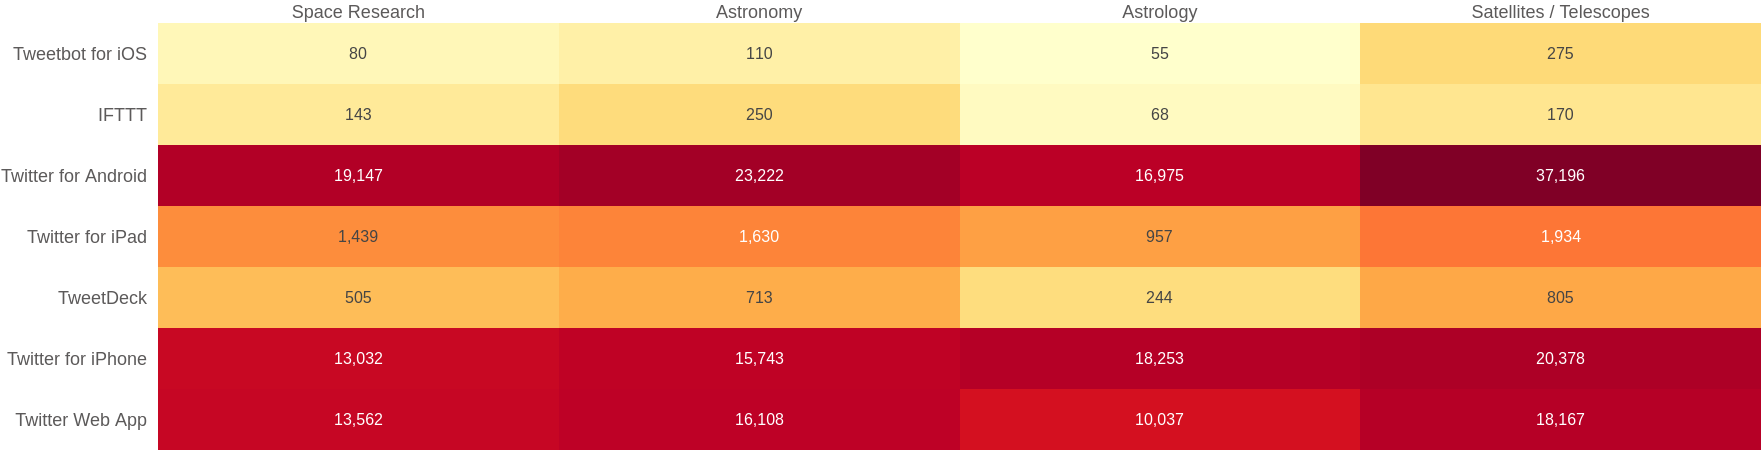

In [265]:
%%time
vh.plot_plotly_heatmap(
    data_dict=data_dict,
    annotation_text=data_dict["annotation_text"],
    margin_dict=dict(l=30, r=0, b=0, t=0, pad=0),
    fig_width=900,
)

**4. Show descriptive statistics (min, mean, median and max) about the number of users followers, by topic**

In [160]:
%%time
# # Pandas
# df_reloaded_pandas.groupby(["dominant_topic_named"], as_index=False)[
#     "user_followers"
# ].agg(["min", "mean", "median", "max"])

# PySpark
df_stats_by_topic_toPandas = df_reloaded_cached.groupby(["dominant_topic_named"]).agg(
    F.min(F.col('user_followers')).alias('user_followers_min'),
    F.avg(F.col('user_followers')).alias('user_followers_mean'),
    # F.percentile_approx("user_followers", 0.5).alias("user_followers_median"),  # pyspark>=3.1.0
    F.expr('percentile(user_followers, array(0.5))')[0].alias('50%'),  # pyspark==2.4.0
    F.max(F.col('user_followers')).alias('user_followers_max'),
).toPandas()
df_stats_by_topic_toPandas

CPU times: user 8.82 ms, sys: 4.01 ms, total: 12.8 ms
Wall time: 1.21 s


,dominant_topic_named,user_followers_min,user_followers_mean,50%,user_followers_max
0,Activities related to Space Research,0,24786.266768,293.0,55791275
1,Astronomy,0,20448.375997,320.0,55776589
2,Astrology,0,9046.980068,288.0,50960953
3,Satellites and Telescopes,0,16608.428706,237.0,55780145


**Observations**
1. Users who tweeted about Astrology have the fewest followers on average.

**5. Show a heatmap of the number of tweets by hour of the day and day of the week, for the most popular topic during every combination of hour and weekday on which Twitter data was streamed. Create a chart from this.**

In [301]:
%%time
# # Pandas
# df_reloaded_pandas.groupby(
#     ["created_at_weekday", "created_at_hour", "dominant_topic_named"], as_index=False
# )["document"].count().sort_values("document", ascending=False).groupby(
#     ["created_at_weekday", "created_at_hour"]
# ).first().reset_index()

# PySpark
df_reloaded_cached_dt_agg = df_reloaded_cached.groupBy(
    ["created_at_date", "created_at_weekday", "created_at_hour", "dominant_topic_named"]
).count().orderBy(["count"], ascending=False)
w = Window.partitionBy(
    ["created_at_date", "created_at_weekday", "created_at_hour"]
).orderBy(F.desc("count"))
df_most_tweeted_topics = df_reloaded_cached_dt_agg.withColumn(
    "row_number", F.row_number().over(w)
).where("row_number = 1").drop("row_number")
df_most_tweeted_topics_toPandas = df_most_tweeted_topics.toPandas()
df_most_tweeted_topics_toPandas

CPU times: user 16.1 ms, sys: 1.45 ms, total: 17.5 ms
Wall time: 4.3 s


,created_at_date,created_at_weekday,created_at_hour,dominant_topic_named,count
0,2022-01-02,Sun,14,Satellites and Telescopes,349
1,2022-01-06,Thu,15,Activities related to Space Research,675
2,2022-01-06,Thu,18,Satellites and Telescopes,1623
3,2022-01-05,Wed,4,Satellites and Telescopes,709
4,2022-01-03,Mon,18,Satellites and Telescopes,390
...,...,...,...,...,...
148,2022-01-04,Tue,18,Satellites and Telescopes,588
149,2022-01-06,Thu,14,Activities related to Space Research,464
150,2022-01-03,Mon,19,Activities related to Space Research,373
151,2022-01-04,Tue,20,Astronomy,443


Convert the `create_at_date` column to a string, which Altair can serialize to JSON

In [350]:
df_most_tweeted_topics_toPandas[date_col_name] = pd.to_datetime(
    df_most_tweeted_topics_toPandas[date_col_name]
).dt.strftime("%Y-%m-%d")

Plot the heatmap

In [381]:
%%time
chart = vh.plot_altair_heatmap(
    data=df_most_tweeted_topics_toPandas,
    legend=alt.Legend(
        title="Average Number of Tweets",
        orient="none",
        legendX=250,
        titleAnchor="start",
        direction="vertical",
    ),
    tooltip=[
        alt.Tooltip("created_at_hour:O", title="Hour"),
        alt.Tooltip("created_at_weekday:N", title="Weekday"),
        alt.Tooltip("created_at_date:N", title="Date"),
        alt.Tooltip("dominant_topic_named:N", title="Topic"),
        alt.Tooltip(f"mean(count):Q", title="Avg. Number of Tweets", format=","),
    ],
    agg="mean",
    xvar="created_at_weekday",
    yvar="created_at_hour",
    color_by_col="count",
    ptitle="Tweets During the Day",
    sort_x=["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"],
    sort_y=list(range(0, 23 + 1)),
    marker_linewidth=1,
    cmap="yelloworangered",
    scale="log",
    show_x_labels=True,
    show_y_labels=True,
    fig_size=(240, 750),
).configure_view(strokeWidth=0).configure_axis(
    domain=False, labelFontSize=14, titleFontSize=16
).configure_title(
    anchor="middle", fontSize=16
).configure_legend(labelFontSize=14)
display(chart)

alt.Chart(...)

CPU times: user 21.6 ms, sys: 0 ns, total: 21.6 ms
Wall time: 26 ms


**6. Did any verified or protected Twitter users posted tweets?**

In [173]:
%%time
df_reloaded_cached.where(F.col("user_protected") == True).count()

CPU times: user 1.69 ms, sys: 230 µs, total: 1.92 ms
Wall time: 160 ms


0

In [174]:
%%time
df_reloaded_cached.where(F.col("user_verified") == True).count()

CPU times: user 1.92 ms, sys: 264 µs, total: 2.18 ms
Wall time: 180 ms


4147

**Observations**
1. There were no tweets by protected users.
2. There were approximately 4,000 tweets by verified users, out of a total of approximately 240,000 tweets with a topic.

**7. In how many tweets is the user's location available? In how many is it missing?**

Count for non-missing and missing values in the `place_country` column

In [175]:
%%time
df_reloaded_cached.where(~F.col("place_country").isNull()).count()

CPU times: user 1.71 ms, sys: 235 µs, total: 1.94 ms
Wall time: 148 ms


1064

In [187]:
%%time
df_reloaded_cached.where(F.col("place_country").isNull()).count()

CPU times: user 1.44 ms, sys: 186 µs, total: 1.62 ms
Wall time: 136 ms


236985

Count for non-missing and missing values in the `user_location` column

In [177]:
%%time
df_reloaded_cached.where(F.col("user_location").isNull()).count()

CPU times: user 1.45 ms, sys: 200 µs, total: 1.65 ms
Wall time: 97.9 ms


0

In [178]:
%%time
df_reloaded_cached.where(F.col("user_location") == "None").count()

CPU times: user 1.65 ms, sys: 228 µs, total: 1.88 ms
Wall time: 201 ms


83872

In [185]:
%%time
df_reloaded_cached.where(~(F.col("user_location") == "None")).count()

CPU times: user 0 ns, sys: 2.11 ms, total: 2.11 ms
Wall time: 562 ms


154177

**Observations**
1. Out of 240,000 tweets
   - approximately 1,000 tweets are not missing a value in the `place_country` column
   - approximately 154,000 tweets are not missing a value in the `user_location` column

**8. What are the 50 user locations from which tweets were posted?**

In [245]:
%%time
# # Pandas
# df_reloaded_pandas["user_location"].value_counts().nlargest(10).to_frame()

# PySpark
df_top_locations_toPandas = (
    df_reloaded_cached
    .where(~(F.col("user_location").isin(["Earth", "Planet Earth", "she/her", "None"])))
    .groupBy(["user_location"])
    .count()
    .orderBy(["count"], ascending=False)
    .toPandas()
)
print(f"Tweets were posted from {df_top_locations_toPandas['user_location'].nunique():,} unique locations")
df_top_locations_toPandas.head(50)

Tweets were posted from 50,118 unique locations
CPU times: user 389 ms, sys: 10 ms, total: 399 ms
Wall time: 2.01 s


,user_location,count
0,United States,1854
1,India,1421
2,"Los Angeles, CA",901
3,"California, USA",899
4,"London, England",844
5,"Washington, DC",795
6,USA,683
7,United Kingdom,638
8,London,590
9,Canada,589


In [246]:
top_50_user_locations = df_top_locations_toPandas["user_location"].head(50).tolist()

**9. Find the name of the country containing the top 50 user locations from question 8.**

In [249]:
%%time
df_reloaded_cached_with_country = df_reloaded_cached.withColumn(
    "country",
    F.when(
        df_reloaded_cached.user_location.like("% CA")
        | df_reloaded_cached.user_location.like("% DC")
        | df_reloaded_cached.user_location.like("% NY")
        | df_reloaded_cached.user_location.like("% WA")
        | df_reloaded_cached.user_location.like("% TX")
        | df_reloaded_cached.user_location.like("% IL")
        | df_reloaded_cached.user_location.like("% FL")
        | df_reloaded_cached.user_location.like("% MD")
        | df_reloaded_cached.user_location.like("% PA")
        | df_reloaded_cached.user_location.like("%, OR")
        | df_reloaded_cached.user_location.like("% MA")
        | df_reloaded_cached.user_location.like("% AZ")
        | df_reloaded_cached.user_location.like("% TX")
        | df_reloaded_cached.user_location.like("% GA")
        | df_reloaded_cached.user_location.like("% USA")
        | (df_reloaded_cached.user_location == "United States")
        | (df_reloaded_cached.user_location.like("Los Angeles%"))
        | (df_reloaded_cached.user_location == "USA")
        | (df_reloaded_cached.user_location.like("Texas"))
        | (df_reloaded_cached.user_location == "Los Angeles"),
        "USA",
    )
    .when(
        (df_reloaded_cached.user_location == "United Kingdom")
        | df_reloaded_cached.user_location.like("% United Kingdom")
        | df_reloaded_cached.user_location.like("% England")
        | (df_reloaded_cached.user_location == "London")
        | (df_reloaded_cached.user_location == "UK"),
        "UK",
    )
    .when(
        df_reloaded_cached.user_location.like("% India")
        | (df_reloaded_cached.user_location == "India"),
        "India",
    )
    .when(
        df_reloaded_cached.user_location == "Australia",
        "Australia",
    )
    .when(
        (df_reloaded_cached.user_location == "Canada")
        | df_reloaded_cached.user_location.like("% Ontario"),
        "Canada",
    )
    .when(
        (df_reloaded_cached.user_location == "Republic of the Philippines")
        | (df_reloaded_cached.user_location == "Philippines"),
        "Philippines",
    )
    .when(
        df_reloaded_cached.user_location == "Indonesia",
        "Indonesia",
    )
    .when(
        df_reloaded_cached.user_location == "None",
        "None",
    )
     .when(
        (df_reloaded_cached.user_location == "France")
        | (df_reloaded_cached.user_location.like("% France")),
        "France",
    )
    .when(
        (df_reloaded_cached.user_location == "Germany")
        | (df_reloaded_cached.user_location == "Deutschland"),
        "Germany",
    )
    .when(
        (df_reloaded_cached.user_location.like("% Kenya")),
        "Kenya",
    )
    .when(
        df_reloaded_cached.user_location.like("%xico%"),
        "Mexico",
    )
    .otherwise("Other"),
)
show_pyspark_df(df_reloaded_cached_with_country, 5)

CPU times: user 26.7 ms, sys: 3.31 ms, total: 30 ms
Wall time: 380 ms


,reviewText_processed,document,created_at,user_joined,in_reply_to_screen_name,source_text,place_country,user_followers,user_friends,user_listed,...,user_verified,user_location,dominant_topic_named,dominant_prob,reviewText_left,reviewText_right,created_at_dt,created_at_hour,created_at_weekday,country
0,updatehunan satellite tv pos...,562285,2022-01-04 12:50:51+00:00,2021-03-22 04:00:37+00:00,None,Twitter for Android,None,501,213,1,...,False,Sail To The Future 🚢,Activities related to Space Research,0.311246,[01.04.2022] 湖南卫视贴吧 UpdateHunan Satellite TV P...,[01.04.2022] 湖南卫视贴吧 UpdateHunan Satellite TV P...,2022-01-04 12:50:51,12,Tue,Other
1,usd juta idr one winner ...,7,2022-01-05 16:00:41+00:00,2018-07-05 12:50:08+00:00,None,Twitter for iPhone,None,237,2772,0,...,False,she/her,Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",2022-01-05 16:00:41,16,Wed,Other
2,usd juta idr one winner ...,11,2022-01-05 16:00:41+00:00,2021-09-19 08:39:09+00:00,None,Twitter Web App,None,84,1055,0,...,False,None,Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",2022-01-05 16:00:41,16,Wed,None
3,usd juta idr one winner ...,21,2022-01-05 16:00:45+00:00,2021-12-31 16:52:25+00:00,None,Twitter for iPhone,None,194,856,0,...,False,"Sakarya, Türkiye",Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",2022-01-05 16:00:45,16,Wed,Other
4,usd juta idr one winner ...,73,2022-01-05 16:00:51+00:00,2021-07-31 10:52:34+00:00,None,Twitter for Android,None,65,1217,0,...,False,None,Satellites and Telescopes,0.425723,"|| 100 USD || 1,4 JUTA IDR |||| one winner || ...","|| 100 USD || 1,4 JUTA IDR |||| one winner || ...",2022-01-05 16:00:51,16,Wed,None


Verify `Other` is not present in the derived country name column

In [250]:
%%time
assert (
    df_reloaded_cached_with_country
    .filter(F.col("user_location").isin(top_50_user_locations))
    .filter(F.col("country") == "Other")
    .select(["user_location", "country"])
    .count()
) == 0

CPU times: user 21.9 ms, sys: 5.3 ms, total: 27.2 ms
Wall time: 685 ms


**10. Count the number of tweets by country, for those tweets originating from any of the top 50 locations (by number of tweets) found in question 8.**

In [303]:
%%time
df_top_50_countries_toPandas = (
    df_reloaded_cached_with_country
    .filter(F.col("user_location").isin(top_50_user_locations))
    .groupBy(["country"])
    .count()
    .orderBy(["count"], ascending=False)
    .toPandas()
)
df_top_50_countries_toPandas

CPU times: user 19.3 ms, sys: 8.74 ms, total: 28 ms
Wall time: 921 ms


,country,count
0,USA,12231
1,UK,2977
2,India,2695
3,Canada,919
4,Philippines,882
5,France,567
6,Indonesia,551
7,Germany,540
8,Australia,437
9,Kenya,237


**11. For each of the countries containing the top 50 user locations (by number of tweets posted) from question 8., count the number of tweets by topic. Create a chart from this.**

For the top 50 user locations, count the number of tweets by country

In [262]:
%%time
df_top_50_countries_grouped = (
    df_reloaded_cached_with_country
    .filter(F.col("user_location").isin(top_50_user_locations))
    .groupBy(["country", "dominant_topic_named"])
    .count()
    .orderBy(["country", "count"], ascending=[True, False])
)
show_pyspark_df(df_top_50_countries_grouped)

CPU times: user 28.2 ms, sys: 4.1 ms, total: 32.3 ms
Wall time: 749 ms


,country,dominant_topic_named,count
0,Australia,Satellites and Telescopes,146
1,Australia,Astronomy,114
2,Australia,Activities related to Space Research,104
3,Australia,Astrology,73
4,Canada,Satellites and Telescopes,289


Pivot the countrywise grouped data keeping country along the rows and topics along the columns

In [263]:
%%time
df_countries_pivotted_toPandas = df_top_50_countries_grouped.groupBy("country").pivot(
    "dominant_topic_named", distinct_column_vals
).sum("count").withColumnRenamed(
    "Activities related to Space Research", "Space Research"
).withColumnRenamed(
    "Satellites and Telescopes", "Satellites / Telescopes"
).toPandas().set_index("country")
df_countries_pivotted_toPandas

CPU times: user 5.94 ms, sys: 3.22 ms, total: 9.16 ms
Wall time: 1.52 s


,Space Research,Astronomy,Astrology,Satellites / Telescopes
country,,,,
Philippines,72,306,210,294
Germany,96,158,53,233
France,118,147,73,229
India,756,858,528,553
USA,2654,3000,2737,3840
Mexico,52,35,35,91
Indonesia,22,33,46,450
UK,762,737,572,906
Canada,220,221,189,289


Re-shape data into format suitable for PlotLy `go.Heatmap()`

In [ ]:
%%time
df_annot = df_countries_pivotted_toPandas.copy()
for col in df_annot:
    df_annot[col] = df_annot[col].map("{:,}".format)
data_dict = vh.convert_df_to_format_for_plotly_heatmap(
    df_countries_pivotted_toPandas, df_annot, True,
)

Plot the heatmap from the reshaped data

CPU times: user 37.2 ms, sys: 3.55 ms, total: 40.7 ms
Wall time: 45 ms


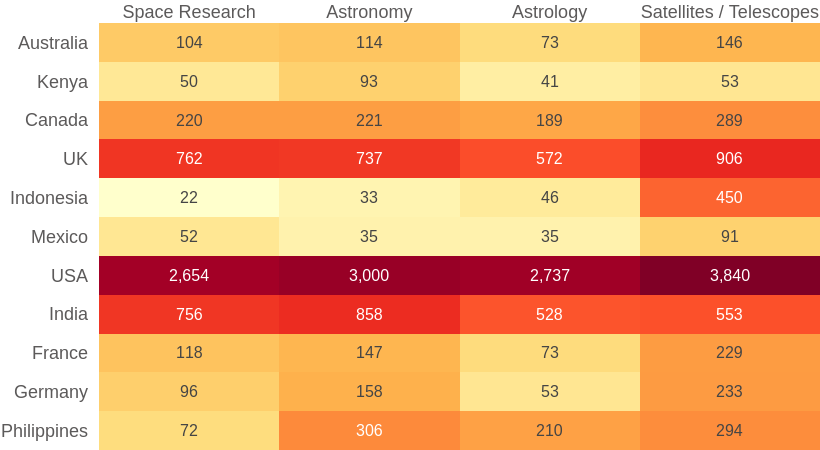

In [261]:
%%time
vh.plot_plotly_heatmap(
    data_dict=data_dict,
    annotation_text=data_dict["annotation_text"],
    margin_dict=dict(l=30, r=0, b=0, t=0, pad=0),
    fig_width=900,
)

## Conclusions and Future Work

### Conclusions
In this preliminary attempt to learn the topics from twitter data, the LDA algorithm has at least suggested topics that can be named based on the top `n` terms within each topic. Manual hyper-parameter tuning has been performed to help with this and the number of topics was also determined by inspecting the top `n` words by weight for each topic. This is a preliminary attempt at topic modeling with PySpark ML.

### Difficulties and Recommendations for Future Work
#### ML Modeling
Using LDA for topic modeling with shorter texts can be challenging ([1](https://towardsdatascience.com/topic-modeling-with-latent-dirichlet-allocation-e7ff75290f8)). The Latent part of LDA refers to the hidden nature of the topics in the documents (tweet texts) ([1](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883), [2](https://www.analyticsvidhya.com/blog/2021/06/part-2-topic-modeling-and-latent-dirichlet-allocation-lda-using-gensim-and-sklearn/)). LDA assumes each document is made up of a distribution of topics and each topic itself is comprised of a distribution of words. With these documents and words, LDA will learn the hidden link (layer) between them ([1](https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14)).i.e. learn the topics. With short texts, there is generally room for only one topic in the text so there can be a larger error in the learned topic probabilities ([3](https://stackoverflow.com/a/29789165)).

Both the length of the text used and the number of text documents in the data influence the efficiency of LDA ([1](https://dl.acm.org/doi/10.5555/3044805.3044828)). For streaming twitter data, the number of documents (tweets) is not such a big problem since we can simply collect more tweets for analysis. However, these tweets need to be long enough to improve the efficiency of using LDA for topic modeling. The overall domain in which the documents fall will have some influence on these two variables.

Recommendations for the minimum number of words required by LDA (in a single document) range from 50-200 to a few thousand ([1](https://towardsdatascience.com/short-text-topic-modeling-70e50a57c883), [2](https://towardsdatascience.com/lda-topic-modeling-with-tweets-deff37c0e131), [3](https://www.researchgate.net/post/What_would_be_considered_the_minimum_length_of_document_minimum_number_of_words_for_training_an_LDA_SLDA_topic_model), [4](https://link.springer.com/article/10.1007/s11135-020-00976-w), [5](https://www.frontiersin.org/articles/10.3389/frai.2020.00042/full)). These are approximations and not hard claims. For the current analysis (tweets related to *space*) even the lower end of this range requires filtering out a lot of tweets and significantly reducing the size of the dataset from one that would require a big-data ML tool (as would be the case with our raw streamed tweets data) such as Spark ML to others that do not have this requirement. This opens up the possibility of using other algorithms that are more equipped to handle shorter texts, such as Gibbs Sampling algorithm for the Dirichlet Multinomial Mixture model (GSDMM) ([1](https://www.semanticscholar.org/paper/A-dirichlet-multinomial-mixture-model-based-for-Yin-Wang/d03ca28403da15e75bc3e90c21eab44031257e80?p2df)), which is [implemented in Python](https://github.com/rwalk/gsdmm) with example uses available ([1](https://stackoverflow.com/a/62331941/4057186), [2](https://towardsdatascience.com/short-text-topic-modelling-lda-vs-gsdmm-20f1db742e14), [3](https://gist.github.com/rrpelgrim/ef88b94f32dff78af4ef3253c93b6436)). Future work should either explore use of this technique for this dataset or assess more references comparing LDA to other unsupervised ML techniques for short texts.

#### Text Data Processing
In the current work, the topics were named using the top words per topic. Removing the *leftover duplicated* tweets from twitter data will help re-affirm or reject these names. As we saw earlier, such duplicates can come in the form of tweets that differ in as little as one word. From reading the documents within each topic, we can see that the further processing is needed to remove such tweets before LDA. So, the top `n` (unique) documents printed for reading contain several of these *leftover duplicates* which makes it difficult to decide if a topic is appropriately named or if it should even exist by reading the documents (tweets) in that topic. Regardless of the ML algorithm used, iteratively removing such *leftover duplicates* will help in
- validating the names of the topics by reading the top (unique) tweets within each topic (without unnecessary duplication)
- fine-tune the number of topics to be learned
- reduce ML model training time

## Summary of Assumptions and Limitations
### Assumptions
1. Re-tweets (identical text in tweet) are not useful to the topic modeling algorithm (LDA). Only a single version of each tweet is sufficient.
2. Regarding short tweets, tweets with more than 25 words in their text can be used with LDA.

### Limitations
1. After processing to replace a double whitespace by a single one, changing to lowercase and trimming the text, the majority of duplicated tweets (which are not retweets) can be removed. Some duplicates, which differ from the original tweet by a single word, remain and (per assumption 1. above) future work should focus on trying to remove these.
2. Preliminary hyper-parameter tuning was performed for TFIDF vectorization and LDA.